# Thermodynamic framework for EVo

This is a thermodynamic framework developed by Kilbride et al. (2016) and refined by Yip et al. (2022).

In this version, we incorporate pre-eruptive exsolved volatile segregation into the thermodynamic model.

This notebook processes output from EVo thermodynamic model (Liggins et al., 2020, 2022) to: 
- visualise magma properties as a function of depth (e.g., volatile content in melt, gas volume fraction, density) 
- calculate observable parameters (e.g., SO₂, volume change and displacement, all normalised by per unit volume erupted)
- simulate pre-eruptive gas accumulation/ loss

EVo thermodynamic model: https://github.com/pipliggins/EVo

For more information, see:
- Liggins et al. 2020 (https://doi.org/10.1016/j.epsl.2020.116546)
- Liggins et al., 2022 (https://doi.org/10.1029/2021JE007123)
- Yip et al., 2022 (https://doi.org/10.1029/2022GC010387)
- Yip et al. (this work)


| Parameters              | $\mathrm{H_2O}$ (wt%) | $\mathrm{CO_2}$ (ppm) | $\mathrm{fO_2}$ | $\mathrm{S}$ (ppm) | Source* |
| :---------------------- | ------------------- | -------------------- | ------------------------- | ----------------- | - |
| Rhyolite sensitivity test  |10.0$\pm$5.0|2.0$\pm$1.0|NNO$\pm$1|3000$\pm$1200|FC|
| Water-poor rhyolite        |5.0|2.0|NNO|3000|FC|
| Water-rich rhyolite        |15.0|2.0|NNO|3000|FC|
| Rhyolite                   |3.3|0.015|NNO|75|MI|
| Ocean island basalt        |1.0|1.0|NNO|1600|MI|
| Arc basalt                 |3.3|1.0|NNO|1600|MI|
*FC: Fractional crystallisation; MI: Melt inclusion

    
||Temperature (K)|Percolation threshold (vol%)|Density（kg$\,$m$^{-3}$）||
|--|--|--|--|--|
|Rhyolite|1123.15|37|2300||
|Basalt|1473.15|17|2800||



## Initialise notebook <a class="anchor" id="Initialisenotebook"></a>

In [20]:
# Set directory
home_dir = input(f"Set home directory (e.g., C:\\Users\\JohnSmith\\EPSL_EVo_framework\\): \n") 


Set home directory (e.g., C:\Users\JohnSmith\EPSL_EVo_framework\): 



In [2]:
# Import packages
import os
import sys
import statistics
import numpy as np
import pandas as pd
import subprocess
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from IPython.display import display, Markdown, Latex
from math import exp, pi
from pandas import Series, DataFrame


In [3]:
# Define functions

# find nearest value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

## Sensitivity test <a class="anchor" id="Sensitivitytest"></a>

In [4]:
# Set constants
magma_comp = 'rhyolite'
shear_modulus = 2100000000
erupted_rock_density = 2300
unit_vol = 1e9
magma_temp = 1123.15 

In [5]:
# Set parameter space to explore
p_allspace = ['H2O', 'CO2', 'S', 'fO2']

# Read in melt inclusion data
df_calc = []
add_df_MI = home_dir + f"E_rhyolite_MI.txt"
df_calc = df_calc + [pd.read_csv(add_df_MI, sep='\t')]

# Explore parameter space
for i_p in range(0, len(p_allspace)):
    p_space = p_allspace[i_p]
    print('\nExploring effects of ' + p_space + ':\n')

    # Read in files from EVo and do calculations
    for i in range(1, 4):
        dcomp_data = home_dir + f"{p_space}_{i}.csv"
        dcomp_calc = home_dir + f"E_{p_space}_{i}_calc.txt"
        df = pd.read_csv(dcomp_data, sep='\t', skiprows=8)
        print(f"Simulating {p_space} {i}")

        # Calculate wt% of volatiles in gas
        H2Ogas = df['wH2O'] * df['Gas_wt']   #change fraction to wt%
        CO2gas = df['wCO2'] * df['Gas_wt'] 
        SO2gas = df['wSO2'] * df['Gas_wt'] 
        H2Sgas = df['wH2S'] * df['Gas_wt'] 

        # Calculate mol% of volatiles in gas
        mH2Ogas = df['mH2O']* df['Gas_wt'] 
        mCO2gas = df['mCO2']* df['Gas_wt'] 
        mSO2gas = df['mSO2']* df['Gas_wt'] 
        mS2gas = df['mS2']* df['Gas_wt'] 
        mH2Sgas = df['mH2S']* df['Gas_wt'] 

        # Calculate wt% of dissolved SO2 
        SO2_melt = df['Stot_melt'] * 64 / 32

        # Calculate wt% of Sulfur in gas
        Sgas1 = []
        k = -1
        for j in range(0, len(df['rho_bulk'])):
            k = k + 1
            Sgas2 = (SO2gas[j] / 64 * 32) + (H2Sgas[j] / 34 * 32)
            Sgas1.append(Sgas2)
        Sgas = np.array(Sgas1)

        #Total moles in 1 m3 magma
        tot_mol_1m3magma = erupted_rock_density * (df['Gas_wt']/100) / df['mol_mass']

        #Volume of fluid in 1 m3 magma
        vol_fluid_1m3magma = tot_mol_1m3magma * 8.31 * magma_temp / (df['P'] * 100000)

        #Mass of SO2 released in 1 m3 magma (kg)
        mS_released = df['mSO2'] * tot_mol_1m3magma * 0.064
        mSulfur_released = (df['mSO2'] * tot_mol_1m3magma * 0.032) + (df['mS2'] * tot_mol_1m3magma * 0.032) + (df['mH2S'] * tot_mol_1m3magma * 0.032)

        #Depth (km)
        depth = df['P'] * 100 / (erupted_rock_density * 9.8)

        #alpha (fluid vol%)
        alpha = vol_fluid_1m3magma * 100

        # Magma compressibility
        dd_dp1 = []  #Change of density with pressure
        k = 0
        for j in range(0, len(df['rho_bulk'])):
            if j == len(df['rho_bulk']) - 1:
                break
            k = k + 1
            dd_dp2 = ((df['rho_bulk'][k - 1] - df['rho_bulk'][k]) /
                      ((df['P'][k - 1] * 100000) - (df['P'][k] * 100000)))
            dd_dp1.append(dd_dp2)
        dd_dp1.insert(0, np.nan)
        dd_dp_bulk = np.array(dd_dp1)

        beta1 = []  #Compressibility = 1/magma density * dd_dp
        for j in range(0, len(df['rho_bulk']) - 1):
            beta2 = ((dd_dp_bulk[j] / df['rho_bulk'][j + 1]))
            beta1.append(beta2)
        beta1[0] = np.nan
        beta1.append(np.nan)
        beta_bulk = np.array(beta1)

        rv1 = []
        for j in range(0, len(beta_bulk)):
            rv2 = ((1 + ((4 * shear_modulus * beta_bulk[j]) / 3)))
            rv1.append(rv2)
        rv1[0] = np.nan
        rv1[-1] = np.nan
        rv_bulk = np.array(rv1)

        # Melt compressibility
        dd_dp1 = []  #Change of density with pressure
        k = 0
        for j in range(0, len(df['rho_melt'])):
            if j == len(df['rho_melt']) - 1:
                break
            k = k + 1
            dd_dp2 = ((df['rho_melt'][k - 1] - df['rho_melt'][k]) /
                      ((df['P'][k - 1] * 100000) - (df['P'][k] * 100000)))
            dd_dp1.append(dd_dp2)
        dd_dp1.insert(0, np.nan)
        dd_dp_melt = np.array(dd_dp1)

        beta1 = []  #Compressibility = 1/magma density * dd_dp
        for j in range(0, len(df['rho_melt']) - 1):
            beta2 = ((dd_dp_melt[j] / df['rho_melt'][j + 1]))
            beta1.append(beta2)
        beta1[0] = np.nan
        beta1.append(np.nan)
        beta_melt = np.array(beta1)

        rv1 = []
        for j in range(0, len(beta_melt)):
            rv2 = ((1 + ((4 * shear_modulus * beta_melt[j]) / 3)))  #/1.75)
            rv1.append(rv2)
        rv1[0] = np.nan
        rv1[-1] = np.nan
        rv_melt = np.array(rv1)

        #Sulfur partition coefficient
        Spart = ((mS_released / unit_vol) /
                 ((1 - (df['Gas_wt']/100)) * erupted_rock_density * df['Stot_melt'] / 100))

        # Vertical displacement
        z_bulk = ((1-0.25)/np.pi)*((1/rv_bulk)/((depth*1000)**2)) *1e9
        z_melt = ((1-0.25)/np.pi)*((1/rv_melt)/((depth*1000)**2)) *1e9

        f = open(dcomp_calc, "w")
        np.savetxt(
            dcomp_calc,
            np.transpose([
                df['P'], depth, df['H2O_melt'], df['CO2_melt'], df['S2-_melt'], df['S6+_melt'],df['Stot_melt'],SO2_melt,
                H2Ogas, CO2gas, SO2gas, Sgas, mH2Ogas, mCO2gas, mSO2gas, mS2gas, mH2Sgas,
                mS_released,mSulfur_released, Spart, df['Exsol_vol%'],
                df['Gas_wt'], df['rho_bulk'], df['rho_melt'], 
                dd_dp_bulk, beta_bulk, rv_bulk, z_bulk, 
                dd_dp_melt, beta_melt, rv_melt, z_melt
            ]),
            fmt='%1.5e',
            delimiter='\t',
            comments='',
            header=
            'Pbar\tdepth\tH2O_melt\tCO2_melt\tS6+_melt\tS2-_melt\tStot_melt\tSO2_melt\tH2Ogas\tCO2gas\tSO2gas\tSgas\tmH2Ogas\tmCO2gas\tmSO2gas\tmS2gas\tmH2Sgas\tmS_released\tmSulfur_released\tSpart\tExsolv_vol_wt\tGas_wt\tRhoBulk\trhomelt\tdd_dp_bulk\tbeta_bulk\trv_bulk\tz_bulk\tdd_dp_melt\tbeta_melt\trv_melt\tz_melt'
        )

        # Read in files
        add_df_calc = home_dir + f"E_{p_space}_{i}_calc.txt"
        df_calc = df_calc + [pd.read_csv(add_df_calc, sep='\t')]


print('\nDone!')
    
# Set range of parameters for labelling figures
if p_space == 'H2O':
    sensitivity1 ='5.0 wt% H$_2$O'
    sensitivity2 ='10.0 wt% H$_2$O'
    sensitivity3 ='15.0 wt% H$_2$O'
elif p_space == 'CO2':
    sensitivity1 ='1.0 wt% CO$_2$'
    sensitivity2 ='2.0 wt% CO$_2$'
    sensitivity3 ='3.0 wt% CO$_2$'
elif p_space == 'fO2':
    sensitivity1 ='NNO-1'
    sensitivity2 ='NNO'
    sensitivity3 ='NNO+1'
elif p_space == 'S':
    sensitivity1 ='1800 p.p.m. S'
    sensitivity2 ='3000 p.p.m. S'
    sensitivity3 ='4200 p.p.m. S'


Exploring effects of H2O:

Simulating H2O 1
Simulating H2O 2
Simulating H2O 3

Exploring effects of CO2:

Simulating CO2 1
Simulating CO2 2
Simulating CO2 3

Exploring effects of S:

Simulating S 1
Simulating S 2
Simulating S 3

Exploring effects of fO2:

Simulating fO2 1
Simulating fO2 2
Simulating fO2 3

Done!


In [6]:
# Set percolation threshold
print('Percolation threshold: Rhyolite = 17 vol%')
min_percolation1=float(np.where(df_calc[1]['Exsolv_vol_wt'] == find_nearest(df_calc[1]['Exsolv_vol_wt'], 17))[0]) #find position of depth closest to res_depth
min_percolation2=float(np.where(df_calc[2]['Exsolv_vol_wt'] == find_nearest(df_calc[2]['Exsolv_vol_wt'], 17))[0]) #find position of depth closest to res_depth
min_percolation3=float(np.where(df_calc[3]['Exsolv_vol_wt'] == find_nearest(df_calc[3]['Exsolv_vol_wt'], 17))[0]) #find position of depth closest to res_depth

min_percolation4=float(np.where(df_calc[4]['Exsolv_vol_wt'] == find_nearest(df_calc[4]['Exsolv_vol_wt'], 17))[0]) #find position of depth closest to res_depth
min_percolation5=float(np.where(df_calc[5]['Exsolv_vol_wt'] == find_nearest(df_calc[5]['Exsolv_vol_wt'], 17))[0]) #find position of depth closest to res_depth
min_percolation6=float(np.where(df_calc[6]['Exsolv_vol_wt'] == find_nearest(df_calc[6]['Exsolv_vol_wt'], 17))[0]) #find position of depth closest to res_depth

min_percolation7=float(np.where(df_calc[7]['Exsolv_vol_wt'] == find_nearest(df_calc[7]['Exsolv_vol_wt'], 17))[0]) #find position of depth closest to res_depth
min_percolation8=float(np.where(df_calc[8]['Exsolv_vol_wt'] == find_nearest(df_calc[8]['Exsolv_vol_wt'], 17))[0]) #find position of depth closest to res_depth
min_percolation9=float(np.where(df_calc[9]['Exsolv_vol_wt'] == find_nearest(df_calc[9]['Exsolv_vol_wt'], 17))[0]) #find position of depth closest to res_depth

min_percolation10=float(np.where(df_calc[10]['Exsolv_vol_wt'] == find_nearest(df_calc[10]['Exsolv_vol_wt'], 17))[0]) #find position of depth closest to res_depth
min_percolation11=float(np.where(df_calc[11]['Exsolv_vol_wt'] == find_nearest(df_calc[11]['Exsolv_vol_wt'], 17))[0]) #find position of depth closest to res_depth
min_percolation12=float(np.where(df_calc[12]['Exsolv_vol_wt'] == find_nearest(df_calc[12]['Exsolv_vol_wt'], 17))[0]) #find position of depth closest to res_depth

# Set reservoir depth
res_depth = float(input('\nSet reservoir depth (km):\n'))


Percolation threshold: Rhyolite = 17 vol%

Set reservoir depth (km):
5


### Fig. 1

Text(-4.2, 1, 'Normalised volume change, $\\overline{V}$')

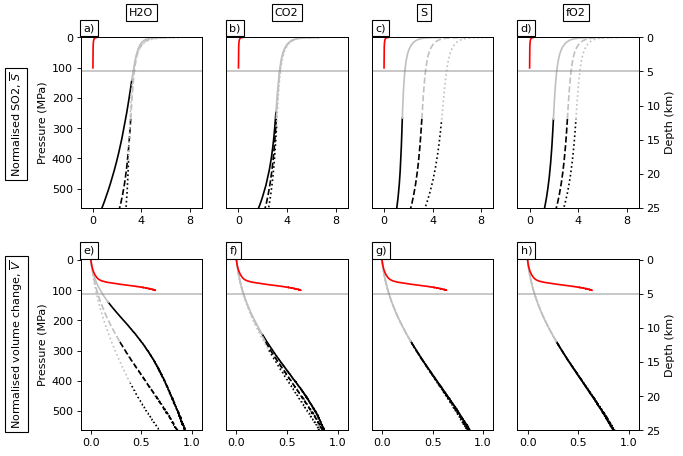

In [7]:
# Plot figure 1
fig = plt.figure(figsize=(9, 10), dpi=80)
fig.subplots_adjust(hspace=0.3)

# Normalised SO2 - H2O
ax1 = fig.add_subplot(3, 4, 1)
ax2 = ax1.twinx()
ax1.plot(df_calc[1]['mS_released'][0:int(min_percolation1)], df_calc[1]['Pbar'][0:int(min_percolation1)]/10, c='k', label=sensitivity1)
ax1.plot(df_calc[2]['mS_released'][0:int(min_percolation2)], df_calc[2]['Pbar'][0:int(min_percolation2)]/10, c='k', label=sensitivity2, linestyle = 'dashed')
ax1.plot(df_calc[3]['mS_released'][0:int(min_percolation3)], df_calc[3]['Pbar'][0:int(min_percolation3)]/10, c='k', label=sensitivity3, linestyle = 'dotted')
ax1.plot(df_calc[1]['mS_released'][int(min_percolation1):-1], df_calc[1]['Pbar'][int(min_percolation1):-1]/10, c='silver')
ax1.plot(df_calc[2]['mS_released'][int(min_percolation2):-1], df_calc[2]['Pbar'][int(min_percolation2):-1]/10, c='silver', linestyle = 'dashed')
ax1.plot(df_calc[3]['mS_released'][int(min_percolation3):-1], df_calc[3]['Pbar'][int(min_percolation3):-1]/10, c='silver', linestyle = 'dotted')
ax1.plot(df_calc[0]['mS_released'], df_calc[0]['Pbar']/10, c='red')
ax1.set_ylim((df_calc[3]['Pbar'].iloc[-1]-27.45)/10, 5635/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[3]['depth'].iloc[-1]-0.1,25)
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(4))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
ax1.set_ylabel('Pressure (MPa)')
ax2.set_yticks([])
# ax1.set_yticks([])
# ax2.set_ylabel('Depth (km)')
ax1.set_xlim(-1, 9)
textstr = 'a' +')'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.025, 1.08, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
textstr = p_allspace[0]
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.4, 1.17, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Normalised SO2 - CO2
ax1 = fig.add_subplot(3, 4, 2)
ax2 = ax1.twinx()
ax1.plot(df_calc[4]['mS_released'][0:int(min_percolation4)], df_calc[4]['Pbar'][0:int(min_percolation4)]/10, c='k', label=sensitivity1)
ax1.plot(df_calc[5]['mS_released'][0:int(min_percolation5)], df_calc[5]['Pbar'][0:int(min_percolation5)]/10, c='k', label=sensitivity2, linestyle = 'dashed')
ax1.plot(df_calc[6]['mS_released'][0:int(min_percolation6)], df_calc[6]['Pbar'][0:int(min_percolation6)]/10, c='k', label=sensitivity3, linestyle = 'dotted')
ax1.plot(df_calc[4]['mS_released'][int(min_percolation4):-1], df_calc[4]['Pbar'][int(min_percolation4):-1]/10, c='silver')
ax1.plot(df_calc[5]['mS_released'][int(min_percolation5):-1], df_calc[5]['Pbar'][int(min_percolation5):-1]/10, c='silver', linestyle = 'dashed')
ax1.plot(df_calc[6]['mS_released'][int(min_percolation6):-1], df_calc[6]['Pbar'][int(min_percolation6):-1]/10, c='silver', linestyle = 'dotted')
ax1.plot(df_calc[0]['mS_released'], df_calc[0]['Pbar']/10, c='red')
ax1.set_ylim((df_calc[3]['Pbar'].iloc[-1]-27.45)/10, 5635/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[3]['depth'].iloc[-1]-0.1,25)
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(4))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
# ax1.set_ylabel('Pressure (MPa)')
ax2.set_yticks([])
ax1.set_yticks([])
# ax2.set_ylabel('Depth (km)')
ax1.set_xlim(-1, 9)
textstr = 'b' +')'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.025, 1.08, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
textstr = p_allspace[1]
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.4, 1.17, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Normalised SO2 - S
ax1 = fig.add_subplot(3, 4, 3)
ax2 = ax1.twinx()
ax1.plot(df_calc[7]['mS_released'][0:int(min_percolation7)], df_calc[7]['Pbar'][0:int(min_percolation7)]/10, c='k', label=sensitivity1)
ax1.plot(df_calc[8]['mS_released'][0:int(min_percolation8)], df_calc[8]['Pbar'][0:int(min_percolation8)]/10, c='k', label=sensitivity2, linestyle = 'dashed')
ax1.plot(df_calc[9]['mS_released'][0:int(min_percolation9)], df_calc[9]['Pbar'][0:int(min_percolation9)]/10, c='k', label=sensitivity3, linestyle = 'dotted')
ax1.plot(df_calc[7]['mS_released'][int(min_percolation7):-1], df_calc[7]['Pbar'][int(min_percolation7):-1]/10, c='silver')
ax1.plot(df_calc[8]['mS_released'][int(min_percolation8):-1], df_calc[8]['Pbar'][int(min_percolation8):-1]/10, c='silver', linestyle = 'dashed')
ax1.plot(df_calc[9]['mS_released'][int(min_percolation9):-1], df_calc[9]['Pbar'][int(min_percolation9):-1]/10, c='silver', linestyle = 'dotted')
ax1.plot(df_calc[0]['mS_released'], df_calc[0]['Pbar']/10, c='red')
ax1.set_ylim((df_calc[3]['Pbar'].iloc[-1]-27.45)/10, 5635/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[3]['depth'].iloc[-1]-0.1,25)
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(4))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
# ax1.set_ylabel('Pressure (MPa)')
ax2.set_yticks([])
ax1.set_yticks([])
# ax2.set_ylabel('Depth (km)')
ax1.set_xlim(-1, 9)
textstr = 'c' +')'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.025, 1.08, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
textstr = p_allspace[2]
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.4, 1.17, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Normalised SO2 - fO2
ax1 = fig.add_subplot(3, 4, 4)
ax2 = ax1.twinx()
ax1.plot(df_calc[10]['mS_released'][0:int(min_percolation10)], df_calc[10]['Pbar'][0:int(min_percolation10)]/10, c='k', label=sensitivity1)
ax1.plot(df_calc[11]['mS_released'][0:int(min_percolation11)], df_calc[11]['Pbar'][0:int(min_percolation11)]/10, c='k', label=sensitivity2, linestyle = 'dashed')
ax1.plot(df_calc[12]['mS_released'][0:int(min_percolation12)], df_calc[12]['Pbar'][0:int(min_percolation12)]/10, c='k', label=sensitivity3, linestyle = 'dotted')
ax1.plot(df_calc[10]['mS_released'][int(min_percolation10):-1], df_calc[10]['Pbar'][int(min_percolation10):-1]/10, c='silver')
ax1.plot(df_calc[11]['mS_released'][int(min_percolation11):-1], df_calc[11]['Pbar'][int(min_percolation11):-1]/10, c='silver', linestyle = 'dashed')
ax1.plot(df_calc[12]['mS_released'][int(min_percolation12):-1], df_calc[12]['Pbar'][int(min_percolation12):-1]/10, c='silver', linestyle = 'dotted')
ax1.plot(df_calc[0]['mS_released'], df_calc[0]['Pbar']/10, c='red')
ax1.set_ylim((df_calc[3]['Pbar'].iloc[-1]-27.45)/10, 5635/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[3]['depth'].iloc[-1]-0.1,25)
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(4))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
# ax1.set_ylabel('Pressure (MPa)')
# ax2.set_yticks([])
ax1.set_yticks([])
ax2.set_ylabel('Depth (km)')
ax1.set_xlim(-1, 9)
textstr = 'd' +')'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.025, 1.08, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
textstr = p_allspace[3]
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.4, 1.17, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

textstr = 'Normalised SO2, $\overline{S}$'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(-4.2, 0.8, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props, rotation=90)


# Normalised SO2 - H2O
ax1 = fig.add_subplot(3, 4, 5)
ax2 = ax1.twinx()
ax1.plot(1/df_calc[1]['rv_bulk'][0:int(min_percolation1):10], df_calc[1]['Pbar'][0:int(min_percolation1):10]/10, c='k', label=sensitivity1)
ax1.plot(1/df_calc[2]['rv_bulk'][0:int(min_percolation2):10], df_calc[2]['Pbar'][0:int(min_percolation2):10]/10, c='k', label=sensitivity2, linestyle = 'dashed')
ax1.plot(1/df_calc[3]['rv_bulk'][0:int(min_percolation3):10], df_calc[3]['Pbar'][0:int(min_percolation3):10]/10, c='k', label=sensitivity3, linestyle = 'dotted')
ax1.plot(1/df_calc[1]['rv_bulk'][int(min_percolation1):-1:10], df_calc[1]['Pbar'][int(min_percolation1):-1:10]/10, c='silver')
ax1.plot(1/df_calc[2]['rv_bulk'][int(min_percolation2):-1:10], df_calc[2]['Pbar'][int(min_percolation2):-1:10]/10, c='silver', linestyle = 'dashed')
ax1.plot(1/df_calc[3]['rv_bulk'][int(min_percolation3):-1:10], df_calc[3]['Pbar'][int(min_percolation3):-1:10]/10, c='silver', linestyle = 'dotted')
ax1.plot(1/df_calc[0]['rv_bulk'][2:], df_calc[0]['Pbar'][2:]/10, c='red')
ax1.set_ylim((df_calc[3]['Pbar'].iloc[-1]-27.45)/10, 5635/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[3]['depth'].iloc[-1]-0.1,25)
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
ax1.set_ylabel('Pressure (MPa)')
ax2.set_yticks([])
# ax1.set_yticks([])
# ax2.set_ylabel('Depth (km)')
ax1.set_xlim(-0.1, 1.1)
textstr = 'e' +')'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.025, 1.08, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Normalised SO2 - CO2
ax1 = fig.add_subplot(3, 4, 6)
ax2 = ax1.twinx()
ax1.plot(1/df_calc[4]['rv_bulk'][0:int(min_percolation4):10], df_calc[4]['Pbar'][0:int(min_percolation4):10]/10, c='k', label=sensitivity1)
ax1.plot(1/df_calc[5]['rv_bulk'][0:int(min_percolation5):10], df_calc[5]['Pbar'][0:int(min_percolation5):10]/10, c='k', label=sensitivity2, linestyle = 'dashed')
ax1.plot(1/df_calc[6]['rv_bulk'][0:int(min_percolation6):10], df_calc[6]['Pbar'][0:int(min_percolation6):10]/10, c='k', label=sensitivity3, linestyle = 'dotted')
ax1.plot(1/df_calc[4]['rv_bulk'][int(min_percolation4):-1:10], df_calc[4]['Pbar'][int(min_percolation4):-1:10]/10, c='silver')
ax1.plot(1/df_calc[5]['rv_bulk'][int(min_percolation5):-1:10], df_calc[5]['Pbar'][int(min_percolation5):-1:10]/10, c='silver', linestyle = 'dashed')
ax1.plot(1/df_calc[6]['rv_bulk'][int(min_percolation6):-1:10], df_calc[6]['Pbar'][int(min_percolation6):-1:10]/10, c='silver', linestyle = 'dotted')
ax1.plot(1/df_calc[0]['rv_bulk'][2:], df_calc[0]['Pbar'][2:]/10, c='red')
ax1.set_ylim((df_calc[3]['Pbar'].iloc[-1]-27.45)/10, 5635/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[3]['depth'].iloc[-1]-0.1,25)
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
# ax1.set_ylabel('Pressure (MPa)')
ax2.set_yticks([])
ax1.set_yticks([])
# ax2.set_ylabel('Depth (km)')
ax1.set_xlim(-0.1, 1.1)
textstr = 'f' +')'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.025, 1.08, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Normalised SO2 - S
ax1 = fig.add_subplot(3, 4, 7)
ax2 = ax1.twinx()
ax1.plot(1/df_calc[7]['rv_bulk'][0:int(min_percolation7):10], df_calc[7]['Pbar'][0:int(min_percolation7):10]/10, c='k', label=sensitivity1)
ax1.plot(1/df_calc[8]['rv_bulk'][0:int(min_percolation8):10], df_calc[8]['Pbar'][0:int(min_percolation8):10]/10, c='k', label=sensitivity2, linestyle = 'dashed')
ax1.plot(1/df_calc[9]['rv_bulk'][0:int(min_percolation9):10], df_calc[9]['Pbar'][0:int(min_percolation9):10]/10, c='k', label=sensitivity3, linestyle = 'dotted')
ax1.plot(1/df_calc[7]['rv_bulk'][int(min_percolation7):-1:10], df_calc[7]['Pbar'][int(min_percolation7):-1:10]/10, c='silver')
ax1.plot(1/df_calc[8]['rv_bulk'][int(min_percolation8):-1:10], df_calc[8]['Pbar'][int(min_percolation8):-1:10]/10, c='silver', linestyle = 'dashed')
ax1.plot(1/df_calc[9]['rv_bulk'][int(min_percolation9):-1:10], df_calc[9]['Pbar'][int(min_percolation9):-1:10]/10, c='silver', linestyle = 'dotted')
ax1.plot(1/df_calc[0]['rv_bulk'][2:], df_calc[0]['Pbar'][2:]/10, c='red')
ax1.set_ylim((df_calc[3]['Pbar'].iloc[-1]-27.45)/10, 5635/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[3]['depth'].iloc[-1]-0.1,25)
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
# ax1.set_ylabel('Pressure (MPa)')
ax2.set_yticks([])
ax1.set_yticks([])
# ax2.set_ylabel('Depth (km)')
ax1.set_xlim(-0.1, 1.1)
textstr = 'g' +')'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.025, 1.08, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Normalised SO2 - fO2
ax1 = fig.add_subplot(3, 4, 8)
ax2 = ax1.twinx()
ax1.plot(1/df_calc[10]['rv_bulk'][0:int(min_percolation10):10], df_calc[10]['Pbar'][0:int(min_percolation10):10]/10, c='k', label=sensitivity1)
ax1.plot(1/df_calc[11]['rv_bulk'][0:int(min_percolation11):10], df_calc[11]['Pbar'][0:int(min_percolation11):10]/10, c='k', label=sensitivity2, linestyle = 'dashed')
ax1.plot(1/df_calc[12]['rv_bulk'][0:int(min_percolation12):10], df_calc[12]['Pbar'][0:int(min_percolation12):10]/10, c='k', label=sensitivity3, linestyle = 'dotted')
ax1.plot(1/df_calc[10]['rv_bulk'][int(min_percolation10):-1:10], df_calc[10]['Pbar'][int(min_percolation10):-1:10]/10, c='silver')
ax1.plot(1/df_calc[11]['rv_bulk'][int(min_percolation11):-1:10], df_calc[11]['Pbar'][int(min_percolation11):-1:10]/10, c='silver', linestyle = 'dashed')
ax1.plot(1/df_calc[12]['rv_bulk'][int(min_percolation12):-1:10], df_calc[12]['Pbar'][int(min_percolation12):-1:10]/10, c='silver', linestyle = 'dotted')
ax1.plot(1/df_calc[0]['rv_bulk'][2:], df_calc[0]['Pbar'][2:]/10, c='red')
ax1.set_ylim((df_calc[3]['Pbar'].iloc[-1]-27.45)/10, 5635/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[3]['depth'].iloc[-1]-0.1,25)
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
# ax1.set_ylabel('Pressure (MPa)')
# ax2.set_yticks([])
ax1.set_yticks([])
ax2.set_ylabel('Depth (km)')
ax1.set_xlim(-0.1, 1.1)
textstr = 'h' +')'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.025, 1.08, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

textstr = 'Normalised volume change, $\overline{V}$'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(-4.2, 1, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props, rotation=90)


## Basalt vs. Rhyolite <a class="anchor" id="basalt_vs_rhyolite"></a>

In [8]:
# Simulating magma properties of basalt and rhyolite
p_space = 'b_vs_r'
for i in range(0, len(p_space)):
    if p_space == p_space:
        print('\nComparison between basalt and rhyolite:\n')
        break
    elif i == len(p_space) - 1:
        sys.exit("Error: please select the correct parameter")

# Explore parameter space
for j in range(0,4):
    k = (['O_1H2O','O_3H2O','R_5H2O','R_15H2O'])
    dcomp_data = home_dir + f"{p_space}_{k[j]}.csv"
    dcomp_calc = home_dir + f"E_{p_space}_{k[j]}_calc.txt"
    df = pd.read_csv(dcomp_data, sep='\t', skiprows=8)
    print(f"Simulating {k[j][0]}: {k[j][2:]}")

    # Calculate wt% of volatiles in gas
    H2Ogas = df['wH2O'] * df['Gas_wt']   #change fraction to wt%
    CO2gas = df['wCO2'] * df['Gas_wt'] 
    SO2gas = df['wSO2'] * df['Gas_wt'] 
    H2Sgas = df['wH2S'] * df['Gas_wt'] 

    # Calculate mol% of volatiles in gas
    mH2Ogas = df['mH2O']* df['Gas_wt'] 
    mCO2gas = df['mCO2']* df['Gas_wt'] 
    mSO2gas = df['mSO2']* df['Gas_wt'] 
    mS2gas = df['mS2']* df['Gas_wt'] 
    mH2Sgas = df['mH2S']* df['Gas_wt'] 

    # Calculate wt% of dissolved SO2 
    SO2_melt = df['Stot_melt'] * 64 / 32

    # Calculate wt% of Sulfur in gas
    Sgas1 = []
    k = -1
    for i in range(0, len(df['rho_bulk'])):
        k = k + 1
        Sgas2 = (SO2gas[i] / 64 * 32) + (H2Sgas[i] / 34 * 32)
        Sgas1.append(Sgas2)
    Sgas = np.array(Sgas1)

    #Total moles in 1 m3 magma
    if j < 2: 
        erupted_rock_density = 2800 #basalt density 
    else: erupted_rock_density = 2300 #rhyolite density
    tot_mol_1m3magma = erupted_rock_density * (df['Gas_wt']/100) / df['mol_mass']

    #Volume of fluid in 1 m3 magma
    vol_fluid_1m3magma = tot_mol_1m3magma * 8.31 * magma_temp / (df['P'] * 100000)

    #Mass of SO2 released in 1 m3 magma (kg)
    mS_released = df['mSO2'] * tot_mol_1m3magma * 0.064
    mSulfur_released = (df['mSO2'] * tot_mol_1m3magma * 0.032) + (df['mS2'] * tot_mol_1m3magma * 0.032) + (df['mH2S'] * tot_mol_1m3magma * 0.032)

    #Depth (km)
    depth = df['P'] * 100 / (erupted_rock_density * 9.8)

    #alpha (fluid vol%)
    alpha = vol_fluid_1m3magma * 100

    # Magma compressibility
    dd_dp1 = []  #Change of density with pressure
    k = 0
    for i in range(0, len(df['rho_bulk'])):
        if i == len(df['rho_bulk']) - 1:
            break
        k = k + 1
        dd_dp2 = ((df['rho_bulk'][k - 1] - df['rho_bulk'][k]) /
                  ((df['P'][k - 1] * 100000) - (df['P'][k] * 100000)))
        dd_dp1.append(dd_dp2)
    dd_dp1.insert(0, np.nan)
    dd_dp_bulk = np.array(dd_dp1)

    beta1 = []  #Compressibility = 1/magma density * dd_dp
    for i in range(0, len(df['rho_bulk']) - 1):
        beta2 = ((dd_dp_bulk[i] / df['rho_bulk'][i + 1]))
        beta1.append(beta2)
    beta1[0] = np.nan
    beta1.append(np.nan)
    beta_bulk = np.array(beta1)

    rv1 = []
    for i in range(0, len(beta_bulk)):
        rv2 = ((1 + ((4 * shear_modulus * beta_bulk[i]) / 3)))
        rv1.append(rv2)
    rv1[0] = np.nan
    rv1[-1] = np.nan
    rv_bulk = np.array(rv1)

    # Melt compressibility
    dd_dp1 = []  #Change of density with pressure
    k = 0
    for i in range(0, len(df['rho_melt'])):
        if i == len(df['rho_melt']) - 1:
            break
        k = k + 1
        dd_dp2 = ((df['rho_melt'][k - 1] - df['rho_melt'][k]) /
                  ((df['P'][k - 1] * 100000) - (df['P'][k] * 100000)))
        dd_dp1.append(dd_dp2)
    dd_dp1.insert(0, np.nan)
    dd_dp_melt = np.array(dd_dp1)

    beta1 = []  #Compressibility = 1/magma density * dd_dp
    for i in range(0, len(df['rho_melt']) - 1):
        beta2 = ((dd_dp_melt[i] / df['rho_melt'][i + 1]))
        beta1.append(beta2)
    beta1[0] = np.nan
    beta1.append(np.nan)
    beta_melt = np.array(beta1)

    rv1 = []
    for i in range(0, len(beta_melt)):
        rv2 = ((1 + ((4 * shear_modulus * beta_melt[i]) / 3)))  #/1.75)
        rv1.append(rv2)
    rv1[0] = np.nan
    rv1[-1] = np.nan
    rv_melt = np.array(rv1)

    #Sulfur partition coefficient
    Spart = ((mS_released / unit_vol) /
             ((1 - (df['Gas_wt']/100)) * erupted_rock_density * df['Stot_melt'] / 100))

    # Vertical displacement
    z_bulk = ((1-0.25)/np.pi)*((1/rv_bulk)/((depth*1000)**2)) *1e9
    z_melt = ((1-0.25)/np.pi)*((1/rv_melt)/((depth*1000)**2)) *1e9

    f = open(dcomp_calc, "w")
    np.savetxt(
        dcomp_calc,
        np.transpose([
            df['P'], depth, df['H2O_melt'], df['CO2_melt'], df['S2-_melt'], df['S6+_melt'],df['Stot_melt'],SO2_melt,
            H2Ogas, CO2gas, SO2gas, Sgas, mH2Ogas, mCO2gas, mSO2gas, mS2gas, mH2Sgas,
            mS_released,mSulfur_released, Spart, df['Exsol_vol%'],
            df['Gas_wt'], df['rho_bulk'], df['rho_melt'], 
            dd_dp_bulk, beta_bulk, rv_bulk, z_bulk, 
            dd_dp_melt, beta_melt, rv_melt, z_melt
        ]),
        fmt='%1.5e',
        delimiter='\t',
        comments='',
        header=
        'Pbar\tdepth\tH2O_melt\tCO2_melt\tS6+_melt\tS2-_melt\tStot_melt\tSO2_melt\tH2Ogas\tCO2gas\tSO2gas\tSgas\tmH2Ogas\tmCO2gas\tmSO2gas\tmS2gas\tmH2Sgas\tmS_released\tmSulfur_released\tSpart\tExsolv_vol_wt\tGas_wt\tRhoBulk\trhomelt\tdd_dp_bulk\tbeta_bulk\trv_bulk\tz_bulk\tdd_dp_melt\tbeta_melt\trv_melt\tz_melt'
    )

# # Read in files
# dcomp_calc_1 = home_dir + f"E_{p_space}_1_calc.txt"
# dcomp_calc_2 = home_dir + f"E_{p_space}_2_calc.txt"
# dcomp_calc_3 = home_dir + f"E_{p_space}_3_calc.txt"
# df_calc = ([0, pd.read_csv(dcomp_calc_1, sep='\t'), pd.read_csv(dcomp_calc_2, sep='\t'), pd.read_csv(dcomp_calc_3, sep='\t')])

# print('\nDone!')
    
# Read in files
df_calc = []
k = (['O_1H2O','O_3H2O','R_5H2O','R_15H2O'])
for j in range(0,4):
    add_df_calc = home_dir + f"E_{p_space}_{k[j]}_calc.txt"
    df_calc = df_calc + [pd.read_csv(add_df_calc, sep='\t')]

print('\nDone!')   

# Set range of parameters for labelling figures
if p_space == 'b_vs_r':
    sensitivity0 ='Basalt: H2O = 1 wt%'
    sensitivity1 ='Basalt: H2O = 3.3 wt%'
    sensitivity2 ='Rhyolite: H2O = 5 wt%'
    sensitivity3 ='Rhyolite: H2O = 1 wt%'



Comparison between basalt and rhyolite:

Simulating O: 1H2O
Simulating O: 3H2O
Simulating R: 5H2O
Simulating R: 15H2O

Done!


In [9]:
# Set percolation threshold
print('Percolation threshold: Basalt = 37 vol%; Rhyolite = 17 vol%')
min_percolation0=np.where(df_calc[0]['Exsolv_vol_wt'] == find_nearest(df_calc[0]['Exsolv_vol_wt'], 37)) #find position of depth closest to res_depth
min_percolation0=float(min_percolation0[0])
min_percolation1=np.where(df_calc[1]['Exsolv_vol_wt'] == find_nearest(df_calc[1]['Exsolv_vol_wt'], 37)) #find position of depth closest to res_depth
min_percolation1=float(min_percolation1[0])
min_percolation2=np.where(df_calc[2]['Exsolv_vol_wt'] == find_nearest(df_calc[2]['Exsolv_vol_wt'], 17)) #find position of depth closest to res_depth
min_percolation2=float(min_percolation2[0])
min_percolation3=np.where(df_calc[3]['Exsolv_vol_wt'] == find_nearest(df_calc[3]['Exsolv_vol_wt'], 17)) #find position of depth closest to res_depth
min_percolation3=float(min_percolation3[0])

# Set reservoir depth
res_depth = float(input('\nSet reservoir depth (km):\n'))

Percolation threshold: Basalt = 37 vol%; Rhyolite = 17 vol%

Set reservoir depth (km):
5


### Fig. 2

Text(0.02, 1.05, 'h)')

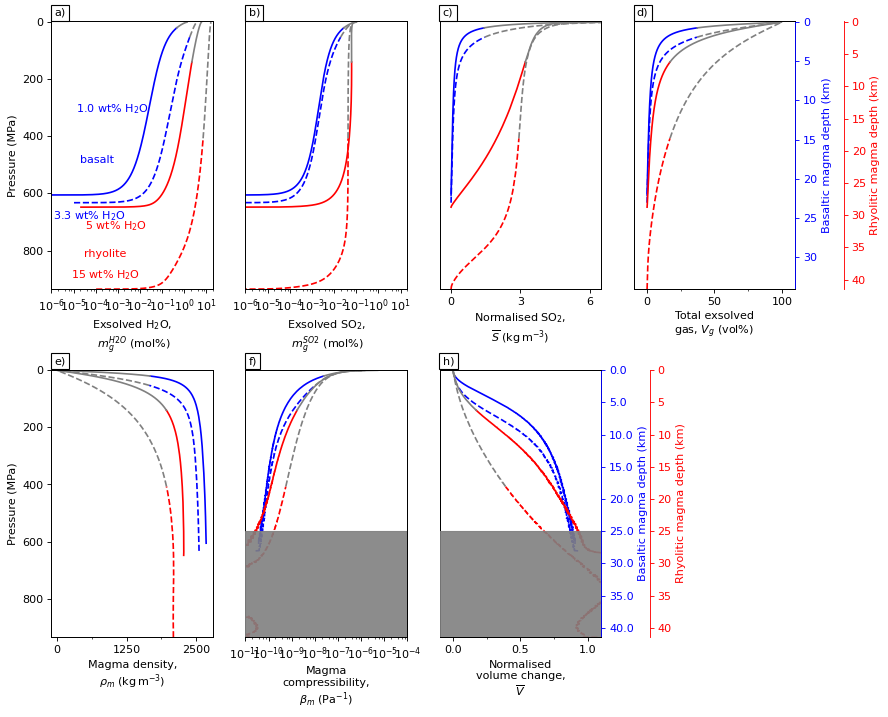

In [10]:
# Plot figure
rv0 = df_calc[0]['beta_bulk'] 
rv1 = df_calc[1]['beta_bulk']
rv2 = df_calc[2]['beta_bulk'] 
rv3 = df_calc[3]['beta_bulk'] 

fig = plt.figure(figsize=(12, 10), dpi=80)
fig.subplots_adjust(hspace=0.3)

# Exsolved H2O
ax1 = fig.add_subplot(2, 4, 1)
ax2 = ax1.twinx()
ax1.plot(df_calc[0]['mH2Ogas'][~np.isnan(rv0)][0:int(min_percolation0)], df_calc[0]['Pbar'][~np.isnan(rv0)][0:int(min_percolation0)]/10, c='b', label=sensitivity0, linestyle = '-')
ax1.plot(df_calc[1]['mH2Ogas'][~np.isnan(rv1)][0:int(min_percolation1)], df_calc[1]['Pbar'][~np.isnan(rv1)][0:int(min_percolation1)]/10, c='b', label=sensitivity1, linestyle = 'dashed')
ax1.plot(df_calc[2]['mH2Ogas'][~np.isnan(rv2)][0:int(min_percolation2)], df_calc[2]['Pbar'][~np.isnan(rv2)][0:int(min_percolation2)]/10, c='r', label=sensitivity2, linestyle = '-')
ax1.plot(df_calc[3]['mH2Ogas'][~np.isnan(rv3)][0:int(min_percolation3)], df_calc[3]['Pbar'][~np.isnan(rv3)][0:int(min_percolation3)]/10, c='r', label=sensitivity3, linestyle = 'dashed')
ax1.plot(df_calc[0]['mH2Ogas'][~np.isnan(rv0)][int(min_percolation0):-1], df_calc[0]['Pbar'][~np.isnan(rv0)][int(min_percolation0):-1]/10, c='grey', label=sensitivity0, linestyle = '-')
ax1.plot(df_calc[1]['mH2Ogas'][~np.isnan(rv1)][int(min_percolation1):-1], df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1]/10, c='grey', label=sensitivity1, linestyle = 'dashed')
ax1.plot(df_calc[2]['mH2Ogas'][~np.isnan(rv2)][int(min_percolation2):-1], df_calc[2]['Pbar'][~np.isnan(rv2)][int(min_percolation2):-1]/10, c='grey', label=sensitivity2, linestyle = '-')
ax1.plot(df_calc[3]['mH2Ogas'][~np.isnan(rv3)][int(min_percolation3):-1], df_calc[3]['Pbar'][~np.isnan(rv3)][int(min_percolation3):-1]/10, c='grey', label=sensitivity3, linestyle = 'dashed')
ax1.set_xlabel('Exsolved H$_2$O,\n $m^{H2O}_{g}$ (mol%)')
ax1.set_ylabel('Pressure (MPa)')
ax1.set_xlim(0.000001, 20)
ax1.set_xscale('log')
ax1.set_ylim((df_calc[3]['Pbar'][~np.isnan(rv3)].iloc[-1]-27.45)/10, df_calc[3]['Pbar'][~np.isnan(rv3)].iloc[0]/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[3]['depth'][~np.isnan(rv3)].iloc[-1]-0.1,df_calc[3]['depth'][~np.isnan(rv3)].iloc[0])
ax2.invert_yaxis()
locmaj = mpl.ticker.LogLocator(base=10, numticks=10)
ax1.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=10)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax2.set_yticks([])
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))
textstr = 'a)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
ax1.text(0.18, 0.5, 'basalt', color='blue', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0.15, 0.7, '1.0 wt% H$_2$O', color='blue', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0.01, 0.3, '3.3 wt% H$_2$O', color='blue', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0.20, 0.15, 'rhyolite', color='red', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0.21, 0.26, '5 wt% H$_2$O', color='red', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0.12, 0.08, '15 wt% H$_2$O', color='red', transform=ax1.transAxes, fontsize=10,verticalalignment='top')

# Exsolved SO2
ax1 = fig.add_subplot(2, 4, 2)
ax2 = ax1.twinx()
ax1.plot(df_calc[0]['mSO2gas'][~np.isnan(rv0)][0:int(min_percolation0)], df_calc[0]['Pbar'][~np.isnan(rv0)][0:int(min_percolation0)]/10, c='b', label=sensitivity0, linestyle = '-')
ax1.plot(df_calc[1]['mSO2gas'][~np.isnan(rv1)][0:int(min_percolation1)], df_calc[1]['Pbar'][~np.isnan(rv1)][0:int(min_percolation1)]/10, c='b', label=sensitivity1, linestyle = 'dashed')
ax1.plot(df_calc[2]['mSO2gas'][~np.isnan(rv2)][0:int(min_percolation2)], df_calc[2]['Pbar'][~np.isnan(rv2)][0:int(min_percolation2)]/10, c='r', label=sensitivity2, linestyle = '-')
ax1.plot(df_calc[3]['mSO2gas'][~np.isnan(rv3)][0:int(min_percolation3)], df_calc[3]['Pbar'][~np.isnan(rv3)][0:int(min_percolation3)]/10, c='r', label=sensitivity3, linestyle = 'dashed')
ax1.plot(df_calc[0]['mSO2gas'][~np.isnan(rv0)][int(min_percolation0):-1], df_calc[0]['Pbar'][~np.isnan(rv0)][int(min_percolation0):-1]/10, c='grey', label=sensitivity0, linestyle = '-')
ax1.plot(df_calc[1]['mSO2gas'][~np.isnan(rv1)][int(min_percolation1):-1], df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1]/10, c='grey', label=sensitivity1, linestyle = 'dashed')
ax1.plot(df_calc[2]['mSO2gas'][~np.isnan(rv2)][int(min_percolation2):-1], df_calc[2]['Pbar'][~np.isnan(rv2)][int(min_percolation2):-1]/10, c='grey', label=sensitivity2, linestyle = '-')
ax1.plot(df_calc[3]['mSO2gas'][~np.isnan(rv3)][int(min_percolation3):-1], df_calc[3]['Pbar'][~np.isnan(rv3)][int(min_percolation3):-1]/10, c='grey', label=sensitivity3, linestyle = 'dashed')
# ax1.legend(loc='lower left')
ax1.set_xlabel('Exsolved SO$_2$,\n $m^{SO2}_{g}$ (mol%)')
ax1.set_xlim(0.000001, 20)
ax1.set_xscale('log')
ax1.set_ylim((df_calc[3]['Pbar'][~np.isnan(rv3)].iloc[-1]-27.45)/10, df_calc[3]['Pbar'][~np.isnan(rv3)].iloc[0]/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[3]['depth'][~np.isnan(rv3)].iloc[-1]-0.1,df_calc[3]['depth'][~np.isnan(rv3)].iloc[0])
ax2.invert_yaxis()
locmaj = mpl.ticker.LogLocator(base=10, numticks=10)
ax1.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=10)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax1.set_yticks([])
ax2.set_yticks([])
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))
textstr = 'b)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Normalised SO2
ax1 = fig.add_subplot(2, 4, 3)
ax2 = ax1.twinx()
ax1.plot(df_calc[0]['mS_released'][~np.isnan(rv0)][0:int(min_percolation0)], df_calc[0]['Pbar'][~np.isnan(rv0)][0:int(min_percolation0)]/10, c='b', label=sensitivity0, linestyle = '-')
ax1.plot(df_calc[1]['mS_released'][~np.isnan(rv1)][0:int(min_percolation1)], df_calc[1]['Pbar'][~np.isnan(rv1)][0:int(min_percolation1)]/10, c='b', label=sensitivity1, linestyle = 'dashed')
ax1.plot(df_calc[2]['mS_released'][~np.isnan(rv2)][0:int(min_percolation2)], df_calc[2]['Pbar'][~np.isnan(rv2)][0:int(min_percolation2)]/10, c='r', label=sensitivity2, linestyle = '-')
ax1.plot(df_calc[3]['mS_released'][~np.isnan(rv3)][0:int(min_percolation3)], df_calc[3]['Pbar'][~np.isnan(rv3)][0:int(min_percolation3)]/10, c='r', label=sensitivity3, linestyle = 'dashed')
ax1.plot(df_calc[0]['mS_released'][~np.isnan(rv0)][int(min_percolation0):-1], df_calc[0]['Pbar'][~np.isnan(rv0)][int(min_percolation0):-1]/10, c='grey', label=sensitivity0, linestyle = '-')
ax1.plot(df_calc[1]['mS_released'][~np.isnan(rv1)][int(min_percolation1):-1], df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1]/10, c='grey', label=sensitivity1, linestyle = 'dashed')
ax1.plot(df_calc[2]['mS_released'][~np.isnan(rv2)][int(min_percolation2):-1], df_calc[2]['Pbar'][~np.isnan(rv2)][int(min_percolation2):-1]/10, c='grey', label=sensitivity2, linestyle = '-')
ax1.plot(df_calc[3]['mS_released'][~np.isnan(rv3)][int(min_percolation3):-1], df_calc[3]['Pbar'][~np.isnan(rv3)][int(min_percolation3):-1]/10, c='grey', label=sensitivity3, linestyle = 'dashed')
# ax1.legend(loc='lower left')
ax1.set_xlabel('Normalised $\mathrm{SO_2}$,\n' + r'$\overline{S}$ (kg$\,$m$^{-3}$)')
ax1.set_ylim((df_calc[3]['Pbar'][~np.isnan(rv3)].iloc[-1]-27.45)/10, df_calc[3]['Pbar'][~np.isnan(rv3)].iloc[0]/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[3]['depth'][~np.isnan(rv3)].iloc[-1]-0.1,df_calc[3]['depth'][~np.isnan(rv3)].iloc[0])
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(3))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))
ax1.set_yticks([])
ax2.set_yticks([])
ax1.set_xlim(-0.5, 6.5)
textstr = 'c)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    
# Total exsolved volatiles
ax1 = fig.add_subplot(2, 4, 4)
ax2 = ax1.twinx()
ax1.plot(df_calc[0]['Exsolv_vol_wt'][~np.isnan(rv0)][0:int(min_percolation0)], df_calc[0]['Pbar'][~np.isnan(rv0)][0:int(min_percolation0)]/10, c='b', label=sensitivity0, linestyle = '-')
ax1.plot(df_calc[1]['Exsolv_vol_wt'][~np.isnan(rv1)][0:int(min_percolation1)], df_calc[1]['Pbar'][~np.isnan(rv1)][0:int(min_percolation1)]/10, c='b', label=sensitivity1, linestyle = 'dashed')
ax1.plot(df_calc[2]['Exsolv_vol_wt'][~np.isnan(rv2)][0:int(min_percolation2)], df_calc[2]['Pbar'][~np.isnan(rv2)][0:int(min_percolation2)]/10, c='r', label=sensitivity2, linestyle = '-')
ax1.plot(df_calc[3]['Exsolv_vol_wt'][~np.isnan(rv3)][0:int(min_percolation3)], df_calc[3]['Pbar'][~np.isnan(rv3)][0:int(min_percolation3)]/10, c='r', label=sensitivity3, linestyle = 'dashed')
ax1.plot(df_calc[0]['Exsolv_vol_wt'][~np.isnan(rv0)][int(min_percolation0):-1], df_calc[0]['Pbar'][~np.isnan(rv0)][int(min_percolation0):-1]/10, c='grey', label=sensitivity0, linestyle = '-')
ax1.plot(df_calc[1]['Exsolv_vol_wt'][~np.isnan(rv1)][int(min_percolation1):-1], df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1]/10, c='grey', label=sensitivity1, linestyle = 'dashed')
ax1.plot(df_calc[2]['Exsolv_vol_wt'][~np.isnan(rv2)][int(min_percolation2):-1], df_calc[2]['Pbar'][~np.isnan(rv2)][int(min_percolation2):-1]/10, c='grey', label=sensitivity2, linestyle = '-')
ax1.plot(df_calc[3]['Exsolv_vol_wt'][~np.isnan(rv3)][int(min_percolation3):-1], df_calc[3]['Pbar'][~np.isnan(rv3)][int(min_percolation3):-1]/10, c='grey', label=sensitivity3, linestyle = 'dashed')
ax1.set_xlabel('Total exsolved\ngas, $V_{g}$ (vol%)')
ax1.set_ylim((df_calc[3]['Pbar'][~np.isnan(rv3)].iloc[-1]-27.45)/10, df_calc[3]['Pbar'][~np.isnan(rv3)].iloc[0]/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[1]['depth'][~np.isnan(rv1)].iloc[-1]-0.1,34.08)
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(25))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
ax2.set_ylabel('Basaltic magma depth (km)')
ax2.spines['right'].set_color('blue')
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax1.set_xlim(-10, 110)
ax1.set_yticks([])
textstr = 'd)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
# set up the 3rd axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(("axes", 1.3))
ax3.set_ylim(df_calc[3]['depth'][~np.isnan(rv3)].iloc[-1]-0.1,df_calc[3]['depth'][~np.isnan(rv3)].iloc[0])
ax3.invert_yaxis()
ax3.set_ylabel('Rhyolitic magma depth (km)')
ax3.spines['right'].set_color('red')
ax3.yaxis.label.set_color('red')
ax3.tick_params(axis='y', colors='red')

# Density
ax1 = fig.add_subplot(2, 4, 5)
ax2 = ax1.twinx()
ax1.plot(df_calc[0]['RhoBulk'][~np.isnan(rv0)][0:int(min_percolation0)], df_calc[0]['Pbar'][~np.isnan(rv0)][0:int(min_percolation0)]/10, c='b', label=sensitivity0, linestyle = '-')
ax1.plot(df_calc[1]['RhoBulk'][~np.isnan(rv1)][0:int(min_percolation1)], df_calc[1]['Pbar'][~np.isnan(rv1)][0:int(min_percolation1)]/10, c='b', label=sensitivity1, linestyle = 'dashed')
ax1.plot(df_calc[2]['RhoBulk'][~np.isnan(rv2)][0:int(min_percolation2)], df_calc[2]['Pbar'][~np.isnan(rv2)][0:int(min_percolation2)]/10, c='r', label=sensitivity2, linestyle = '-')
ax1.plot(df_calc[3]['RhoBulk'][~np.isnan(rv3)][0:int(min_percolation3)], df_calc[3]['Pbar'][~np.isnan(rv3)][0:int(min_percolation3)]/10, c='r', label=sensitivity3, linestyle = 'dashed')
ax1.plot(df_calc[0]['RhoBulk'][~np.isnan(rv0)][int(min_percolation0):-1], df_calc[0]['Pbar'][~np.isnan(rv0)][int(min_percolation0):-1]/10, c='grey', label=sensitivity0, linestyle = '-')
ax1.plot(df_calc[1]['RhoBulk'][~np.isnan(rv1)][int(min_percolation1):-1], df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1]/10, c='grey', label=sensitivity1, linestyle = 'dashed')
ax1.plot(df_calc[2]['RhoBulk'][~np.isnan(rv2)][int(min_percolation2):-1], df_calc[2]['Pbar'][~np.isnan(rv2)][int(min_percolation2):-1]/10, c='grey', label=sensitivity2, linestyle = '-')
ax1.plot(df_calc[3]['RhoBulk'][~np.isnan(rv3)][int(min_percolation3):-1], df_calc[3]['Pbar'][~np.isnan(rv3)][int(min_percolation3):-1]/10, c='grey', label=sensitivity3, linestyle = 'dashed')
ax1.set_xlabel('Magma density,\n' + r'$\rho_{m}$ (kg$\,$m$^{-3}$)')
ax1.set_ylabel('Pressure (MPa)')
ax1.set_ylim((df_calc[3]['Pbar'][~np.isnan(rv3)].iloc[-1]-27.45)/10, df_calc[3]['Pbar'][~np.isnan(rv3)].iloc[0]/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[3]['depth'][~np.isnan(rv3)].iloc[-1]-0.1,df_calc[3]['depth'][~np.isnan(rv3)].iloc[0])
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1250))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(625))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))
ax1.set_xlim(-100, 2800)
ax2.set_yticks([])
textstr = 'e)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
  
# Compressibility
ax1 = fig.add_subplot(2, 4, 6)
ax2 = ax1.twinx()
ax1.plot(df_calc[0]['beta_bulk'][~np.isnan(rv0)][1:int(min_percolation0):10], df_calc[0]['Pbar'][~np.isnan(rv0)][1:int(min_percolation0):10]/10, c='b', label=sensitivity0, linestyle = '-')
ax1.plot(df_calc[1]['beta_bulk'][~np.isnan(rv1)][1:int(min_percolation1):10], df_calc[1]['Pbar'][~np.isnan(rv1)][1:int(min_percolation1):10]/10, c='b', label=sensitivity1, linestyle = 'dashed')
ax1.plot(df_calc[2]['beta_bulk'][~np.isnan(rv2)][1:int(min_percolation2):10], df_calc[2]['Pbar'][~np.isnan(rv2)][1:int(min_percolation2):10]/10, c='r', label=sensitivity2, linestyle = '-')
ax1.plot(df_calc[3]['beta_bulk'][~np.isnan(rv3)][1:int(min_percolation3):10], df_calc[3]['Pbar'][~np.isnan(rv3)][1:int(min_percolation3):10]/10, c='r', label=sensitivity3, linestyle = 'dashed')
ax1.plot(df_calc[0]['beta_bulk'][~np.isnan(rv0)][int(min_percolation0):-1:10], df_calc[0]['Pbar'][~np.isnan(rv0)][int(min_percolation0):-1:10]/10, c='grey', label=sensitivity0, linestyle = '-')
ax1.plot(df_calc[1]['beta_bulk'][~np.isnan(rv1)][int(min_percolation1):-1:10], df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1:10]/10, c='grey', label=sensitivity1, linestyle = 'dashed')
ax1.plot(df_calc[2]['beta_bulk'][~np.isnan(rv2)][int(min_percolation2):-1:10], df_calc[2]['Pbar'][~np.isnan(rv2)][int(min_percolation2):-1:10]/10, c='grey', label=sensitivity2, linestyle = '-')
ax1.plot(df_calc[3]['beta_bulk'][~np.isnan(rv3)][int(min_percolation3):-1:10], df_calc[3]['Pbar'][~np.isnan(rv3)][int(min_percolation3):-1:10]/10, c='grey', label=sensitivity3, linestyle = 'dashed')
ax1.set_xlabel('Magma\ncompressibility,\n' + r'$\beta_{m}$ (Pa$^{-1}$)')
ax1.set_xscale('log')
ax1.set_xlim(0.00000000001, 0.0001)
ax1.set_ylim((df_calc[3]['Pbar'][~np.isnan(rv3)].iloc[-1]-27.45)/10, df_calc[3]['Pbar'][~np.isnan(rv3)].iloc[0]/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[3]['depth'][~np.isnan(rv3)].iloc[-1]-0.1,df_calc[3]['depth'][~np.isnan(rv3)].iloc[0])
ax2.invert_yaxis()
locmaj = mpl.ticker.LogLocator(base=10, numticks=10)
ax1.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=10)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))
ax1.set_yticks([])
ax2.set_yticks([])
rect = mpl.patches.Rectangle((0.00000000001,df_calc[3]['depth'][~np.isnan(rv3)].iloc[0]), 0.0001+0.00000000001, 25-df_calc[3]['depth'][~np.isnan(rv3)].iloc[0], linewidth=1, edgecolor='gray', facecolor='gray', zorder=3, alpha = 0.9)
ax2.add_patch(rect)
textstr = 'f)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Normalised volume change
ax1 = fig.add_subplot(2, 4, 7)
ax2 = ax1.twinx()
ax1.plot(1/df_calc[0]['rv_bulk'][~np.isnan(rv0)][1:int(min_percolation0):10], df_calc[0]['Pbar'][~np.isnan(rv0)][1:int(min_percolation0):10]/10, c='b', label=sensitivity0, linestyle = '-')
ax1.plot(1/df_calc[1]['rv_bulk'][~np.isnan(rv1)][1:int(min_percolation1):10], df_calc[1]['Pbar'][~np.isnan(rv1)][1:int(min_percolation1):10]/10, c='b', label=sensitivity1, linestyle = 'dashed')
ax1.plot(1/df_calc[2]['rv_bulk'][~np.isnan(rv2)][1:int(min_percolation2):10], df_calc[2]['Pbar'][~np.isnan(rv2)][1:int(min_percolation2):10]/10, c='r', label=sensitivity2, linestyle = '-')
ax1.plot(1/df_calc[3]['rv_bulk'][~np.isnan(rv3)][1:int(min_percolation3):10], df_calc[3]['Pbar'][~np.isnan(rv3)][1:int(min_percolation3):10]/10, c='r', label=sensitivity3, linestyle = 'dashed')
ax1.plot(1/df_calc[0]['rv_bulk'][~np.isnan(rv0)][int(min_percolation0):-1:10], df_calc[0]['Pbar'][~np.isnan(rv0)][int(min_percolation0):-1:10]/10, c='grey', label=sensitivity0, linestyle = '-')
ax1.plot(1/df_calc[1]['rv_bulk'][~np.isnan(rv1)][int(min_percolation1):-1:10], df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1:10]/10, c='grey', label=sensitivity1, linestyle = 'dashed')
ax1.plot(1/df_calc[2]['rv_bulk'][~np.isnan(rv2)][int(min_percolation2):-1:10], df_calc[2]['Pbar'][~np.isnan(rv2)][int(min_percolation2):-1:10]/10, c='grey', label=sensitivity2, linestyle = '-')
ax1.plot(1/df_calc[3]['rv_bulk'][~np.isnan(rv3)][int(min_percolation3):-1:10], df_calc[3]['Pbar'][~np.isnan(rv3)][int(min_percolation3):-1:10]/10, c='grey', label=sensitivity3, linestyle = 'dashed')
ax1.set_xlabel('Normalised\nvolume change,\n$\overline{V}$')
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim((df_calc[3]['Pbar'][~np.isnan(rv3)].iloc[-1]-27.45)/10, df_calc[3]['Pbar'][~np.isnan(rv3)].iloc[0]/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[3]['depth'][~np.isnan(rv3)].iloc[-1]-0.1,df_calc[3]['depth'][~np.isnan(rv3)].iloc[0])
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))
ax1.set_yticks([])
ax2.set_ylabel('Basaltic magma depth (km)')
ax2.spines['right'].set_color('blue')
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax1.set_yticks([])

# set up the 3rd axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(("axes", 1.3))
ax3.set_ylim(df_calc[3]['depth'][~np.isnan(rv3)].iloc[-1]-0.1,df_calc[3]['depth'][~np.isnan(rv3)].iloc[0])
ax3.invert_yaxis()
ax3.set_ylabel('Rhyolitic magma depth (km)')
ax3.spines['right'].set_color('red')
ax3.yaxis.label.set_color('red')
ax3.tick_params(axis='y', colors='red')
rect = mpl.patches.Rectangle((-0.5,df_calc[3]['depth'][~np.isnan(rv3)].iloc[0]), 7, 25-df_calc[3]['depth'][~np.isnan(rv3)].iloc[0], linewidth=1, edgecolor='gray', facecolor='gray', zorder=3, alpha = 0.9)
ax3.add_patch(rect)
textstr = 'h)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

## Gas segregation <a class="anchor" id="GASSEG"></a>

In [11]:
# Simulating gas segregation
p_space = 'GASSEG'
for i in range(0, len(p_space)):
    if p_space == p_space:
        print('\nExploring effects of ' + p_space + ':\n')
        break
    elif i == len(p_space) - 1:
        sys.exit("Error: please select the correct parameter")

# Explore parameter space
for j in range(0,5):
    k = ([-1.0, -0.5, 0, 0.5, 1.0])
    dcomp_data = home_dir + f"{p_space}_{k[j]}.csv"
    dcomp_calc = home_dir + f"E_{p_space}_{k[j]}_calc.txt"
    df = pd.read_csv(dcomp_data, sep='\t', skiprows=8)
    print(f"Simulating k = {k[j]} for {p_space}") 
    
    # Calculate wt% of volatiles in gas
    H2Ogas = df['wH2O'] * df['Gas_wt'] * (1 + k[j])   #change fraction to wt%
    CO2gas = df['wCO2'] * df['Gas_wt'] * (1 + k[j]) 
    SO2gas = df['wSO2'] * df['Gas_wt'] * (1 + k[j]) 
    H2Sgas = df['wH2S'] * df['Gas_wt'] * (1 + k[j]) 

    # Calculate mol% of volatiles in gas
    mH2Ogas = df['mH2O']* df['Gas_wt'] * (1 + k[j])
    mCO2gas = df['mCO2']* df['Gas_wt'] * (1 + k[j])
    mSO2gas = df['mSO2']* df['Gas_wt'] * (1 + k[j])
    mS2gas = df['mS2']* df['Gas_wt'] * (1 + k[j])
    mH2Sgas = df['mH2S']* df['Gas_wt'] * (1 + k[j])

    # Calculate wt% of dissolved SO2 
    SO2_melt = df['Stot_melt'] * 64 / 32

    #Total moles in 1 m3 magma
    tot_mol_1m3magma = erupted_rock_density * (df['Gas_wt']/100) / df['mol_mass']

    #Volume of fluid in 1 m3 magma
    vol_fluid_1m3magma = tot_mol_1m3magma * 8.31 * 1473.15 / (df['P'] * 100000)

    #Mass of SO2 released in 1 m3 magma (kg)
    mS_released = df['mSO2'] * tot_mol_1m3magma * 0.064  * (1 + k[j])
    mSulfur_released = ((df['mSO2'] * tot_mol_1m3magma * 0.032) + (df['mS2'] * tot_mol_1m3magma * 0.032) + (df['mH2S'] * tot_mol_1m3magma * 0.032)) * (1 + k[j])

    # Calculate wt% of Sulfur in gas
    Sgas1 = []
    k = -1
    for i in range(0, len(df['rho_bulk'])):
        k = k + 1
        Sgas2 = ((SO2gas[i] / 64 * 32) + (H2Sgas[i] / 34 * 32)) 
        Sgas1.append(Sgas2)
    Sgas = np.array(Sgas1)

    #Depth (km)
    depth = df['P'] * 100 / (erupted_rock_density * 9.8)

    #alpha (fluid vol%)
    alpha = vol_fluid_1m3magma * 100

    # Magma compressibility
    dd_dp1 = []  #Change of density with pressure
    k = 0
    for i in range(0, len(df['rho_bulk'])):
        if i == len(df['rho_bulk']) - 1:
            break
        k = k + 1
        dd_dp2 = ((df['rho_bulk'][k - 1] - df['rho_bulk'][k]) /
                  ((df['P'][k - 1] * 100000) - (df['P'][k] * 100000)))
        dd_dp1.append(dd_dp2)
    dd_dp1.insert(0, np.nan)
    dd_dp_bulk = np.array(dd_dp1)

    beta1 = []  #Compressibility = 1/magma density * dd_dp
    for i in range(0, len(df['rho_bulk']) - 1):
        beta2 = ((dd_dp_bulk[i] / df['rho_bulk'][i + 1]))
        beta1.append(beta2)
    beta1[0] = np.nan
    beta1.append(np.nan)
    beta_bulk = np.array(beta1)

    rv1 = []
    for i in range(0, len(beta_bulk)):
        rv2 = ((1 + ((4 * shear_modulus * beta_bulk[i]) / 3)))
        rv1.append(rv2)
    rv1[0] = np.nan
    rv1[-1] = np.nan
    rv_bulk = np.array(rv1)

    # Melt compressibility
    dd_dp1 = []  #Change of density with pressure
    k = 0
    for i in range(0, len(df['rho_melt'])):
        if i == len(df['rho_melt']) - 1:
            break
        k = k + 1
        dd_dp2 = ((df['rho_melt'][k - 1] - df['rho_melt'][k]) /
                  ((df['P'][k - 1] * 100000) - (df['P'][k] * 100000)))
        dd_dp1.append(dd_dp2)
    dd_dp1.insert(0, np.nan)
    dd_dp_melt = np.array(dd_dp1)

    beta1 = []  #Compressibility = 1/magma density * dd_dp
    for i in range(0, len(df['rho_melt']) - 1):
        beta2 = ((dd_dp_melt[i] / df['rho_melt'][i + 1]))
        beta1.append(beta2)
    beta1[0] = np.nan
    beta1.append(np.nan)
    beta_melt = np.array(beta1)

    rv1 = []
    for i in range(0, len(beta_melt)):
        rv2 = ((1 + ((4 * shear_modulus * beta_melt[i]) / 3)))  #/1.75)
        rv1.append(rv2)
    rv1[0] = np.nan
    rv1[-1] = np.nan
    rv_melt = np.array(rv1)

    #Sulfur partition coefficient
    Spart = ((mS_released / unit_vol) /
             ((1 - (df['Gas_wt']/100)) * erupted_rock_density * df['Stot_melt'] / 100))

    # Vertical displacement
    z_bulk = ((1-0.25)/np.pi)*((1/rv_bulk)/((depth*1000)**2)) *1e9
    z_melt = ((1-0.25)/np.pi)*((1/rv_melt)/((depth*1000)**2)) *1e9

    f = open(dcomp_calc, "w")
    np.savetxt(
        dcomp_calc,
        np.transpose([
            df['P'], depth, df['H2O_melt'], df['CO2_melt'], df['S2-_melt'], df['S6+_melt'],df['Stot_melt'],SO2_melt,
            H2Ogas, CO2gas, SO2gas, Sgas, mH2Ogas, mCO2gas, mSO2gas, mS2gas, mH2Sgas,
            mS_released,mSulfur_released, Spart, df['Exsol_vol%'],
            df['Gas_wt'], df['rho_bulk'], df['rho_melt'], 
            dd_dp_bulk, beta_bulk, rv_bulk, z_bulk, 
            dd_dp_melt, beta_melt, rv_melt, z_melt
        ]),
        fmt='%1.5e',
        delimiter='\t',
        comments='',
        header=
        'Pbar\tdepth\tH2O_melt\tCO2_melt\tS6+_melt\tS2-_melt\tStot_melt\tSO2_melt\tH2Ogas\tCO2gas\tSO2gas\tSgas\tmH2Ogas\tmCO2gas\tmSO2gas\tmS2gas\tmH2Sgas\tmS_released\tmSulfur_released\tSpart\tExsolv_vol_wt\tGas_wt\tRhoBulk\trhomelt\tdd_dp_bulk\tbeta_bulk\trv_bulk\tz_bulk\tdd_dp_melt\tbeta_melt\trv_melt\tz_melt'
    )


# Read in files
df_calc = []
k = ([-1.0, -0.5, 0, 0.5, 1.0])
for j in range(0,5):
    add_df_calc = home_dir + f"E_{p_space}_{k[j]}_calc.txt"
    df_calc = df_calc + [pd.read_csv(add_df_calc, sep='\t')]

print('\nDone!')   

# Set range of parameters for labelling figures
if p_space == 'GASSEG':
    sensitivity0 ='k = -1'
    sensitivity1 ='k = -0.5'
    sensitivity2 ='k = 0'
    sensitivity3 ='k = +0.5'
    sensitivity4 ='k = +1'



Exploring effects of GASSEG:

Simulating k = -1.0 for GASSEG
Simulating k = -0.5 for GASSEG
Simulating k = 0 for GASSEG
Simulating k = 0.5 for GASSEG
Simulating k = 1.0 for GASSEG

Done!


In [12]:
# Set percolation threshold
print('Set percolation threshold (Rhyolite = 17 vol%):\n')
min_percolation1=np.where(0.5*df_calc[1]['Exsolv_vol_wt'] == find_nearest(0.5*df_calc[1]['Exsolv_vol_wt'], 17)) #find position of depth closest to res_depth
min_percolation1=float(min_percolation1[0])
min_percolation2=np.where(1.0*df_calc[2]['Exsolv_vol_wt'] == find_nearest(1.0*df_calc[2]['Exsolv_vol_wt'], 17)) #find position of depth closest to res_depth
min_percolation2=float(min_percolation2[0])
min_percolation3=np.where(1.5*df_calc[3]['Exsolv_vol_wt'] == find_nearest(1.5*df_calc[3]['Exsolv_vol_wt'], 17)) #find position of depth closest to res_depth
min_percolation3=float(min_percolation3[0])
min_percolation4=np.where(2*df_calc[4]['Exsolv_vol_wt'] == find_nearest(2*df_calc[3]['Exsolv_vol_wt'], 17)) #find position of depth closest to res_depth
min_percolation4=float(min_percolation4[0])

# Set reservoir depth
res_depth = float(input('\nSet reservoir depth (km):\n'))
rv0 = df_calc[0]['beta_bulk']
rv1 = df_calc[1]['beta_bulk']
rv2 = df_calc[2]['beta_bulk']
rv3 = df_calc[3]['beta_bulk']
rv4 = df_calc[4]['beta_bulk']

Set percolation threshold (Rhyolite = 17 vol%):


Set reservoir depth (km):
5


### Fig. 4

Text(0.02, 1.05, 'f)')

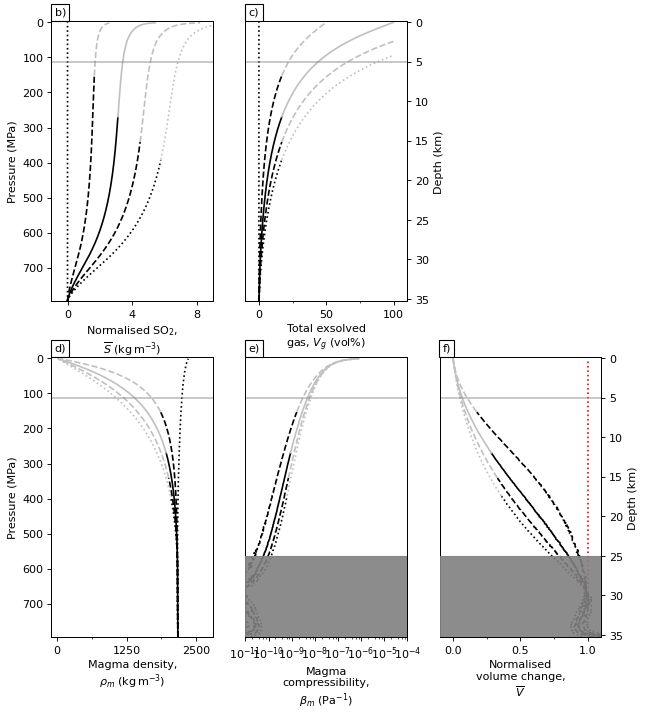

In [13]:
# Results
plt.figure(figsize=(12,10), dpi=80)
gs = plt.GridSpec(2,4)

# Normalised SO2
ax1 = plt.subplot(gs[0,0])
ax2 = ax1.twinx()
ax1.plot(df_calc[0]['mS_released'][~np.isnan(rv0)], df_calc[0]['Pbar'][~np.isnan(rv0)]/10, c='k', linestyle = 'dotted')
ax1.plot(df_calc[1]['mS_released'][~np.isnan(rv1)][0:int(min_percolation1):20], df_calc[1]['Pbar'][~np.isnan(rv1)][0:int(min_percolation1):20]/10, c='k', linestyle = 'dashed')
ax1.plot(df_calc[1]['mS_released'][~np.isnan(rv1)][int(min_percolation1):-1:20], df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1:20]/10, c='silver', linestyle = 'dashed')
ax1.plot(df_calc[2]['mS_released'][~np.isnan(rv2)][0:int(min_percolation2):20], df_calc[2]['Pbar'][~np.isnan(rv2)][0:int(min_percolation2):20]/10, c='k', linestyle = '-')
ax1.plot(df_calc[2]['mS_released'][~np.isnan(rv2)][int(min_percolation2):-1:20], df_calc[2]['Pbar'][~np.isnan(rv2)][int(min_percolation2):-1:20]/10, c='silver', linestyle = '-')
ax1.plot(df_calc[3]['mS_released'][~np.isnan(rv3)][0:int(min_percolation3):20], df_calc[3]['Pbar'][~np.isnan(rv3)][0:int(min_percolation3):20]/10, c='k', linestyle = 'dashed')
ax1.plot(df_calc[3]['mS_released'][~np.isnan(rv3)][int(min_percolation3):-1:20], df_calc[3]['Pbar'][~np.isnan(rv3)][int(min_percolation3):-1:20]/10, c='silver', linestyle = 'dashed')
ax1.plot(df_calc[4]['mS_released'][~np.isnan(rv4)][0:int(min_percolation4):20], df_calc[4]['Pbar'][~np.isnan(rv4)][0:int(min_percolation4):20]/10, c='k', linestyle = 'dotted')
ax1.plot(df_calc[4]['mS_released'][~np.isnan(rv4)][int(min_percolation4):-1:20], df_calc[4]['Pbar'][~np.isnan(rv4)][int(min_percolation4):-1:20]/10, c='silver', linestyle = 'dotted')
ax1.set_xlabel('Normalised $\mathrm{SO_2}$,\n' + r'$\overline{S}$ (kg$\,$m$^{-3}$)')
ax1.set_ylabel('Pressure (MPa)')
ax1.set_ylim((df_calc[2]['Pbar'].iloc[-1]-27.45)/10, df_calc[2]['Pbar'].iloc[0]/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[2]['depth'].iloc[-1]-0.1,df_calc[2]['depth'].iloc[0])
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(4))
ax2.set_yticks([])
ax1.set_xlim(-1, 9)
textstr = 'b)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Remove Vgas > 100
Exsolv_vol_wt_1_5 = (1.5*df_calc[3]['Exsolv_vol_wt']<100).to_numpy().nonzero()[0]
Exsolv_vol_wt_1_5 = np.delete(Exsolv_vol_wt_1_5,0)
Exsolv_vol_wt_2 = (2.0*df_calc[4]['Exsolv_vol_wt']<100).to_numpy().nonzero()[0]
Exsolv_vol_wt_2 = np.delete(Exsolv_vol_wt_2,0)

# Total exsolved volatiles
ax1 = plt.subplot(gs[0,1])
ax2 = ax1.twinx()
ax1.plot(0*df_calc[0]['Exsolv_vol_wt'][~np.isnan(rv0)], df_calc[0]['Pbar'][~np.isnan(rv0)], c='k', linestyle = 'dotted')
ax1.plot(0.5*df_calc[1]['Exsolv_vol_wt'][~np.isnan(rv1)][0:int(min_percolation1):20], df_calc[1]['Pbar'][~np.isnan(rv1)][0:int(min_percolation1):20], c='k', linestyle = 'dashed')
ax1.plot(0.5*df_calc[1]['Exsolv_vol_wt'][~np.isnan(rv1)][int(min_percolation1):-1:20], df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1:20], c='silver', linestyle = 'dashed')
ax1.plot(1*df_calc[2]['Exsolv_vol_wt'][~np.isnan(rv2)][0:int(min_percolation2)], df_calc[2]['Pbar'][~np.isnan(rv2)][0:int(min_percolation2)], c='k', linestyle = '-')
ax1.plot(1*df_calc[2]['Exsolv_vol_wt'][~np.isnan(rv2)][int(min_percolation2):-1], df_calc[2]['Pbar'][~np.isnan(rv2)][int(min_percolation2):-1], c='silver', linestyle = '-')
ax1.plot(1.5*df_calc[3]['Exsolv_vol_wt'][~np.isnan(rv3)][Exsolv_vol_wt_1_5][0:int(min_percolation3)], df_calc[3]['Pbar'][~np.isnan(rv3)][Exsolv_vol_wt_1_5][0:int(min_percolation3)], c='k', linestyle = 'dashed')
ax1.plot(1.5*df_calc[3]['Exsolv_vol_wt'][~np.isnan(rv3)][Exsolv_vol_wt_1_5][int(min_percolation3):-1], df_calc[3]['Pbar'][~np.isnan(rv3)][Exsolv_vol_wt_1_5][int(min_percolation3):-1], c='silver', linestyle = 'dashed')
ax1.plot(2*df_calc[4]['Exsolv_vol_wt'][~np.isnan(rv4)][Exsolv_vol_wt_2][0:int(min_percolation4)], df_calc[4]['Pbar'][~np.isnan(rv4)][Exsolv_vol_wt_2][0:int(min_percolation4)], c='k', linestyle = 'dotted')
ax1.plot(2*df_calc[4]['Exsolv_vol_wt'][~np.isnan(rv4)][Exsolv_vol_wt_2][int(min_percolation4):-1], df_calc[4]['Pbar'][~np.isnan(rv4)][Exsolv_vol_wt_2][int(min_percolation4):-1], c='silver', linestyle = 'dotted')
ax1.set_xlabel('Total exsolved\ngas, $V_{g}$ (vol%)')
ax1.set_ylim((df_calc[2]['Pbar'].iloc[-1]-27.45), df_calc[2]['Pbar'].iloc[0])
ax1.invert_yaxis()
ax2.set_ylim(df_calc[2]['depth'].iloc[-1]-0.1,df_calc[2]['depth'].iloc[0])
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(25))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
ax2.set_ylabel('Depth (km)')
ax1.set_xlim(-10, 110)
ax1.set_yticks([])
textstr = 'c)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Remove melt data < 0
dd_dp_melt_nonzero = (df_calc[0]['dd_dp_melt']>0).to_numpy().nonzero()[0]
dd_dp_melt_nonzero = np.delete(dd_dp_melt_nonzero,0)

# Density
ax1 = plt.subplot(gs[1,0])
ax2 = ax1.twinx()
ax1.plot(df_calc[0]['RhoBulk'][~np.isnan(rv0)][0:-1:20], df_calc[0]['Pbar'][~np.isnan(rv0)][0:-1:20]/10, c='k', linestyle = 'dotted')
ax1.plot(df_calc[1]['RhoBulk'][~np.isnan(rv1)][0:int(min_percolation1):20], df_calc[1]['Pbar'][~np.isnan(rv1)][0:int(min_percolation1):20]/10, c='k', linestyle = 'dashed')
ax1.plot(df_calc[1]['RhoBulk'][~np.isnan(rv1)][int(min_percolation1):-1:20], df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1:20]/10, c='silver', linestyle = 'dashed')
ax1.plot(df_calc[2]['RhoBulk'][~np.isnan(rv2)][0:int(min_percolation2):20], df_calc[2]['Pbar'][~np.isnan(rv2)][0:int(min_percolation2):20]/10, c='k', linestyle = '-')
ax1.plot(df_calc[2]['RhoBulk'][~np.isnan(rv2)][int(min_percolation2):-1:20], df_calc[2]['Pbar'][~np.isnan(rv2)][int(min_percolation2):-1:20]/10, c='silver', linestyle = '-')
ax1.plot(df_calc[3]['RhoBulk'][~np.isnan(rv3)][0:int(min_percolation3):20], df_calc[3]['Pbar'][~np.isnan(rv3)][0:int(min_percolation3):20]/10, c='k', linestyle = 'dashed')
ax1.plot(df_calc[3]['RhoBulk'][~np.isnan(rv3)][int(min_percolation3):-1:20], df_calc[3]['Pbar'][~np.isnan(rv3)][int(min_percolation3):-1:20]/10, c='silver', linestyle = 'dashed')
ax1.plot(df_calc[4]['RhoBulk'][~np.isnan(rv4)][0:int(min_percolation4):20], df_calc[4]['Pbar'][~np.isnan(rv4)][0:int(min_percolation4):20]/10, c='k', linestyle = 'dotted')
ax1.plot(df_calc[4]['RhoBulk'][~np.isnan(rv4)][int(min_percolation4):-1:20], df_calc[4]['Pbar'][~np.isnan(rv4)][int(min_percolation4):-1:20]/10, c='silver', linestyle = 'dotted')
ax1.set_xlabel('Magma density,\n' + r'$\rho_{m}$ (kg$\,$m$^{-3}$)')
ax1.set_ylabel('Pressure (MPa)')
ax1.set_ylim((df_calc[2]['Pbar'].iloc[-1]-27.45)/10, df_calc[2]['Pbar'].iloc[0]/10)
ax1.invert_yaxis()
ax2.set_ylim(df_calc[2]['depth'].iloc[-1]-0.1,df_calc[2]['depth'].iloc[0])
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1250))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(625))
ax1.set_xlim(-100, 2800)
ax2.set_yticks([])
textstr = 'd)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)


# Compressibility
ax1 = plt.subplot(gs[1,1])
ax2 = ax1.twinx()
ax1.plot(df_calc[0]['beta_bulk'][~np.isnan(rv0)][dd_dp_melt_nonzero][0:-1:20], df_calc[0]['Pbar'][~np.isnan(rv0)][dd_dp_melt_nonzero][0:-1:20], c='k', linestyle = 'dotted')
ax1.plot(df_calc[1]['beta_bulk'][~np.isnan(rv1)][1:int(min_percolation1):20], df_calc[1]['Pbar'][~np.isnan(rv1)][1:int(min_percolation1):20], c='k', linestyle = 'dashed')
ax1.plot(df_calc[1]['beta_bulk'][~np.isnan(rv1)][int(min_percolation1):-1:20], df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1:20], c='silver', linestyle = 'dashed')
ax1.plot(df_calc[2]['beta_bulk'][~np.isnan(rv2)][1:int(min_percolation2):20], df_calc[2]['Pbar'][~np.isnan(rv2)][1:int(min_percolation2):20], c='k', linestyle = '-')
ax1.plot(df_calc[2]['beta_bulk'][~np.isnan(rv2)][int(min_percolation2):-1:20], df_calc[2]['Pbar'][~np.isnan(rv2)][int(min_percolation2):-1:20], c='silver', linestyle = '-')
ax1.plot(df_calc[3]['beta_bulk'][~np.isnan(rv3)][1:int(min_percolation3):20], df_calc[3]['Pbar'][~np.isnan(rv3)][1:int(min_percolation3):20], c='k', linestyle = 'dashed')
ax1.plot(df_calc[3]['beta_bulk'][~np.isnan(rv3)][int(min_percolation3):-1:20], df_calc[3]['Pbar'][~np.isnan(rv3)][int(min_percolation3):-1:20], c='silver', linestyle = 'dashed')
ax1.plot(df_calc[4]['beta_bulk'][~np.isnan(rv4)][1:int(min_percolation4):20], df_calc[4]['Pbar'][~np.isnan(rv4)][1:int(min_percolation4):20], c='k', linestyle = 'dotted')
ax1.plot(df_calc[4]['beta_bulk'][~np.isnan(rv4)][int(min_percolation4):-1:20], df_calc[4]['Pbar'][~np.isnan(rv4)][int(min_percolation4):-1:20], c='silver', linestyle = 'dotted')
ax1.set_xlabel('Magma\ncompressibility,\n' + r'$\beta_{m}$ (Pa$^{-1}$)')
ax1.set_xscale('log')
ax1.set_xlim(0.00000000001, 0.0001)
ax1.set_ylim((df_calc[2]['Pbar'].iloc[-1]-27.45), df_calc[2]['Pbar'].iloc[0])
ax1.invert_yaxis()
ax2.set_ylim(df_calc[2]['depth'].iloc[-1]-0.1,df_calc[2]['depth'].iloc[0])
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
ax2.invert_yaxis()
locmaj = mpl.ticker.LogLocator(base=10, numticks=10)
ax1.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=10)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
ax1.set_yticks([])
ax2.set_yticks([])
rect = mpl.patches.Rectangle((0.00000000001,df_calc[3]['depth'].iloc[0]), 0.0001+0.00000000001, 25-df_calc[3]['depth'].iloc[0], linewidth=1, edgecolor='gray', facecolor='gray', zorder=3, alpha = 0.9)
ax2.add_patch(rect)
textstr = 'e)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)


# Normalised volume change
ax1 = plt.subplot(gs[1,2])
ax2 = ax1.twinx()
ax1.plot(1/df_calc[0]['rv_bulk'][~np.isnan(rv0)][dd_dp_melt_nonzero][0:-1:20], df_calc[0]['Pbar'][~np.isnan(rv0)][dd_dp_melt_nonzero][0:-1:20], c='k', linestyle = 'dotted')
ax1.plot(np.ones(len(df_calc[0]['rv_bulk']))[~np.isnan(rv0)][0:-1:20], df_calc[0]['Pbar'][~np.isnan(rv0)][0:-1:20], c='r', linestyle = 'dotted')
ax1.plot(1/df_calc[1]['rv_bulk'][~np.isnan(rv1)][1:int(min_percolation1):20], df_calc[1]['Pbar'][~np.isnan(rv1)][1:int(min_percolation1):20], c='k', linestyle = 'dashed')
ax1.plot(1/df_calc[1]['rv_bulk'][~np.isnan(rv1)][int(min_percolation1):-1:20], df_calc[1]['Pbar'][~np.isnan(rv1)][int(min_percolation1):-1:20], c='silver', linestyle = 'dashed')
ax1.plot(1/df_calc[2]['rv_bulk'][~np.isnan(rv2)][1:int(min_percolation2):20], df_calc[2]['Pbar'][~np.isnan(rv2)][1:int(min_percolation2):20], c='k', linestyle = '-')
ax1.plot(1/df_calc[2]['rv_bulk'][~np.isnan(rv2)][int(min_percolation2):-1:20], df_calc[2]['Pbar'][~np.isnan(rv2)][int(min_percolation2):-1:20], c='silver', linestyle = '-')
ax1.plot(1/df_calc[3]['rv_bulk'][~np.isnan(rv3)][1:int(min_percolation3):20], df_calc[3]['Pbar'][~np.isnan(rv3)][1:int(min_percolation3):20], c='k', linestyle = 'dashed')
ax1.plot(1/df_calc[3]['rv_bulk'][~np.isnan(rv3)][int(min_percolation3):-1:20], df_calc[3]['Pbar'][~np.isnan(rv3)][int(min_percolation3):-1:20], c='silver', linestyle = 'dashed')
ax1.plot(1/df_calc[4]['rv_bulk'][~np.isnan(rv4)][1:int(min_percolation4):20], df_calc[4]['Pbar'][~np.isnan(rv4)][1:int(min_percolation4):20], c='k', linestyle = 'dotted')
ax1.plot(1/df_calc[4]['rv_bulk'][~np.isnan(rv4)][int(min_percolation4):-1:20], df_calc[4]['Pbar'][~np.isnan(rv4)][int(min_percolation4):-1:20], c='silver', linestyle = 'dotted')
ax1.set_xlabel('Normalised\nvolume change,\n$\overline{V}$')
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim((df_calc[2]['Pbar'].iloc[-1]-27.45), df_calc[2]['Pbar'].iloc[0])
ax1.invert_yaxis()
ax2.set_ylim(df_calc[2]['depth'].iloc[-1]-0.1,df_calc[2]['depth'].iloc[0])
ax2.axhline(y=res_depth, color='grey', alpha=0.5)
#         ax2.axvline(x=1, color='k', linestyle = 'dotted')
ax2.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax1.set_yticks([])
ax2.set_ylabel('Depth (km)')
rect = mpl.patches.Rectangle((-0.1,df_calc[3]['depth'].iloc[0]), 1.2, 25-df_calc[3]['depth'].iloc[0], linewidth=1, edgecolor='gray', facecolor='gray', zorder=9, alpha = 0.9)
ax2.add_patch(rect)
textstr = 'f)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.02, 1.05, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)




## Observed eruptions <a class="anchor" id="Observations"></a>

In [14]:
# Read in eruption data
dcomp_data = home_dir + 'normalised_data.txt'
df_obs = pd.read_csv(dcomp_data, sep='\t')

# Observed eruptions
obs_Volcano_Name=df_obs['Volcano Name']
obs_Erupt_start=df_obs['Start date (dd/mm/yy)']
obs_Erupt_end=df_obs['End date (dd/mm/yy)']
obs_Erupt_duration=df_obs['Eruption duration (days)']
obs_Rock_Type=df_obs['Dominant Magma Composition']
obs_Tectonic_Setting=df_obs['Tectonic Setting']
obs_SATOBS_DEF=df_obs['Deformation detected by satellites']
obs_SATOBS_SO2=df_obs['SO2 degassing detected by satellites']
obs_Chamber_geometry=df_obs['Chamber geometry']
obs_Depth=df_obs['Depth (km)']
obs_Depth_min=df_obs['Min. depth (km)']
obs_Depth_max=df_obs['Max. depth (km)']
obs_Coeruptive_degassing=df_obs['Co-eruptive degassing']
obs_SO2=df_obs['SO2 emission (Tg)']
obs_SO2_min=df_obs['Min. SO2 (Tg)']
obs_SO2_max=df_obs['Max. SO2 (Tg)']
obs_Deformation_source=df_obs['Deformation source']
obs_Vc=df_obs['Volume change (km3)']
obs_Vc_min=df_obs['Min. volume change (km3)']
obs_Vc_max=df_obs['Max. volume change (km3)']
obs_Ve=df_obs['Volume erupted (km3)']
obs_Ve_min=df_obs['Min. erupted (km3)']
obs_Ve_max=df_obs['Max. erupted (km3)']
obs_Vbar=df_obs['Normalised volume change']
obs_Vbar_min=df_obs['Min. normalised volume change']
obs_Vbar_max=df_obs['Max. normalised volume change']
obs_Sbar=df_obs['Normalised SO2 (Tg km-3)']
obs_Sbar_min=df_obs['Min. normalised SO2 (Tg km-3)']
obs_Sbar_max=df_obs['Max. normalised SO2 (Tg km-3)']


### Fig. 5

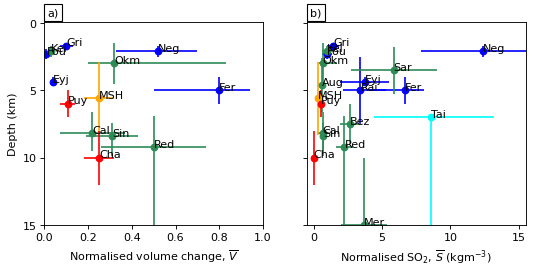

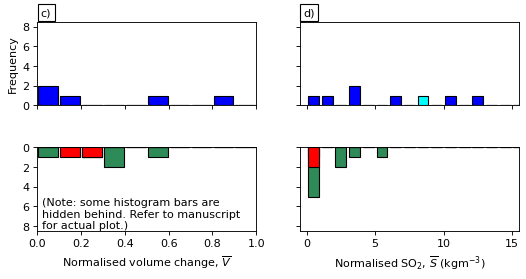

In [15]:
# plot all combined

fig = plt.figure(figsize=(12,10), dpi=80)
gs = plt.GridSpec(3,3)
gs.update(hspace=0.25,top=1)

# Normalised volume change
ax1 = plt.subplot(gs[0,0])
ax1.errorbar(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
             xerr=[df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                   df_obs['Min. normalised volume change'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
                  df_obs['Max. normalised volume change'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                  df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']],
             color='blue', fmt='o', mfc='blue',label='Basalt / Picro-Basalt')
ax1.errorbar(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
             xerr=[df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                   df_obs['Min. normalised volume change'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
                  df_obs['Max. normalised volume change'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                  df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']],
             color='seagreen', fmt='o', mfc='seagreen',label='Andesite / Basaltic Andesite')
ax1.errorbar(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Dacite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite'],
             xerr=[df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Dacite']-
                   df_obs['Min. normalised volume change'][df_obs['Dominant Magma Composition']=='Dacite'],
                  df_obs['Max. normalised volume change'][df_obs['Dominant Magma Composition']=='Dacite']-
                  df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Dacite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Dacite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']],
             color='orange', fmt='o', mfc='orange',label='Dacite')
ax1.errorbar(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Rhyolite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
             xerr=[df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                   df_obs['Min. normalised volume change'][df_obs['Dominant Magma Composition']=='Rhyolite'],
                  df_obs['Max. normalised volume change'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                  df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Rhyolite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']],
             color='red', fmt='o', mfc='red',label='Rhyolite')
ax1.set_xlabel('Normalised volume change, $\overline{V}$')
ax1.set_xlim(0,1)
ax1.set_ylim(-0.09635569,15)
ax1.invert_yaxis()
ax1.set_ylabel('Depth (km)')
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax1.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
textstr = 'a)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.015, 1.07, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
# ax1.text(0.7, 0.8,  'Silica-poor', color = 'blue', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
# ax1.text(0.55, 0.3,  'Silica-rich', color = 'red', transform=ax1.transAxes, fontsize=10,verticalalignment='top')

# Volcano names
for print_volname in range(len(df_obs['Volume change (km3)'])):
    if ~np.isnan(df_obs['Normalised volume change'][print_volname]) == True and df_obs['Normalised volume change'][print_volname]<15 and df_obs['Depth (km)'][print_volname]<15.1:
        if df_obs['Dominant Magma Composition'][print_volname] == 'Basalt / Picro-Basalt' or df_obs['Dominant Magma Composition'][print_volname] == 'Trachybasalt / Tephrite Basanite' or df_obs['Dominant Magma Composition'][print_volname] == 'Andesite / Basaltic Andesite' or df_obs['Dominant Magma Composition'][print_volname] == 'Dacite' or df_obs['Dominant Magma Composition'][print_volname] == 'Rhyolite':
            ax1.text(df_obs['Normalised volume change'][~np.isnan(df_obs['Normalised volume change'])][print_volname],
                     df_obs['Depth (km)'][~np.isnan(df_obs['Normalised volume change'])][print_volname],
                     df_obs['Volcano Name'][~np.isnan(df_obs['Normalised volume change'])][print_volname][0:3])
            
# Silicic normalised SO2 - sulfur content
ax1 = plt.subplot(gs[0,1])
ax1.errorbar(df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
             xerr=[df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                   df_obs['Min. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
                  df_obs['Max. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                  df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']],
             color='blue', fmt='o', mfc='blue',label='Basalt / Picro-Basalt')
ax1.errorbar(df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite'],
             xerr=[df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite']-
                   df_obs['Min. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite'],
                  df_obs['Max. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite']-
                  df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite']],
             color='cyan', fmt='o', mfc='cyan',label='Trachybasalt / Tephrite Basanite')
ax1.errorbar(df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
             xerr=[df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                   df_obs['Min. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
                  df_obs['Max. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                  df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']],
             color='seagreen', fmt='o', mfc='seagreen',label='Andesite / Basaltic Andesite')
ax1.errorbar(df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Dacite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite'],
             xerr=[df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Dacite']-
                   df_obs['Min. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Dacite'],
                  df_obs['Max. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Dacite']-
                  df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Dacite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Dacite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']],
             color='orange', fmt='o', mfc='orange',label='Dacite')
ax1.errorbar(df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
             xerr=[df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                   df_obs['Min. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
                  df_obs['Max. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                  df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Rhyolite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']],
             color='red', fmt='o', mfc='red',label='Rhyolite')
ax1.set_xlabel('Normalised $\mathrm{SO_2}$, ' + r'$\overline{S}$ (kgm$^{-3}$)')
ax1.set_xlim(-0.5, 15.5)
ax1.set_ylim(-0.09635569,15)
ax1.invert_yaxis()
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax1.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax1.yaxis.set_ticklabels([])
textstr = 'b)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.015, 1.07, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
# ax1.text(0.3, 0.1,  'Silica-poor', color = 'blue', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
# ax1.text(0.1, 0.2,  'Silica-rich', color = 'red', transform=ax1.transAxes, fontsize=10,verticalalignment='top')

# Volcano names
for print_volname in range(len(df_obs['Volume change (km3)'])):
    if ~np.isnan(df_obs['Normalised SO2 (Tg km-3)'][print_volname]) == True and df_obs['Normalised SO2 (Tg km-3)'][print_volname]<15 and df_obs['Depth (km)'][print_volname]<15.1:
        if df_obs['Dominant Magma Composition'][print_volname] == 'Basalt / Picro-Basalt' or df_obs['Dominant Magma Composition'][print_volname] == 'Trachybasalt / Tephrite Basanite' or df_obs['Dominant Magma Composition'][print_volname] == 'Andesite / Basaltic Andesite' or df_obs['Dominant Magma Composition'][print_volname] == 'Dacite' or df_obs['Dominant Magma Composition'][print_volname] == 'Rhyolite':
            ax1.text(df_obs['Normalised SO2 (Tg km-3)'][~np.isnan(df_obs['Normalised SO2 (Tg km-3)'])][print_volname],
                     df_obs['Depth (km)'][~np.isnan(df_obs['Normalised SO2 (Tg km-3)'])][print_volname],
                     df_obs['Volcano Name'][~np.isnan(df_obs['Normalised SO2 (Tg km-3)'])][print_volname][0:3])
            
# Histogram
fig = plt.figure(figsize=(12,10), dpi=80)
gs = plt.GridSpec(6,3)
gs.update(hspace=0.5,top=1)
# Normalised SO2
ax1 = plt.subplot(gs[1,0])
kwargs = dict(alpha=1, edgecolor = 'k', bins=np.linspace(0,1,11), rwidth=0.9)
ax1.hist(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'][~np.isnan(df_obs['Normalised volume change'])], **kwargs ,  color= 'blue', label='Basalt / Picro-Basalt')
ax1.hist(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite'][~np.isnan(df_obs['Normalised volume change'])], **kwargs ,  color= 'cyan', label='Trachybasalt / Tephrite Basanite')
ax1.set_xlim(-0.0,1.0)
ax1.set_ylim(0,8.5)
ax1.set_ylabel('Frequency')
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
# ax1.set_xlabel('Normalised volume change, ' + r'$\overline{V}$')
ax1.xaxis.set_ticklabels([])
# ax1.legend(bbox_to_anchor=(2.1, 0.7))
textstr = 'c)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.016, 1.17, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

ax1 = plt.subplot(gs[1,1])
kwargs = dict(alpha=1, edgecolor = 'k', bins=range(0,20), rwidth=0.8)
ax1.hist(df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'][~np.isnan(df_obs['Normalised SO2 (Tg km-3)'])], **kwargs ,  color= 'blue', label='Basalt / Picro-Basalt')
ax1.hist(df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite'][~np.isnan(df_obs['Normalised SO2 (Tg km-3)'])], **kwargs ,  color= 'cyan', label='Trachybasalt / Tephrite Basanite')
ax1.set_xlim(-0.5,15.5)
ax1.set_ylim(0,8.5)
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
# ax1.set_xlabel('Normalised $\mathrm{SO_2}$, ' + r'$\overline{S}$ (kgm$^{-3}$)')
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
textstr = 'd)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.016, 1.17, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

ax1 = plt.subplot(gs[2,0])
kwargs = dict(alpha=1, edgecolor = 'k', bins=np.linspace(0,1,11), rwidth=0.9)
ax1.hist(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'][~np.isnan(df_obs['Normalised volume change'])], **kwargs ,  color= 'seagreen', label='Andesite / Basaltic Andesite')
ax1.hist(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Dacite'][~np.isnan(df_obs['Normalised volume change'])], **kwargs ,  color= 'orange', label='Dacite')
ax1.hist(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Rhyolite'][~np.isnan(df_obs['Normalised volume change'])], **kwargs ,  color= 'red', label='Rhyolite')
ax1.set_xlim(-0.0,1.0)
ax1.set_ylim(0,8.5)
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax1.set_xlabel('Normalised volume change, ' + r'$\overline{V}$')
plt.gca().invert_yaxis()
textstr = '(Note: some histogram bars are\nhidden behind. Refer to manuscript\nfor actual plot.)'
ax1.text(0.02, 0.4, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top')

ax1 = plt.subplot(gs[2,1])
kwargs = dict(alpha=1, edgecolor = 'k', bins=range(0,20), rwidth=0.8)
ax1.hist(df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'][~np.isnan(df_obs['Normalised SO2 (Tg km-3)'])], **kwargs ,  color= 'seagreen', label='Andesite / Basaltic Andesite')
ax1.hist(df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Dacite'][~np.isnan(df_obs['Normalised SO2 (Tg km-3)'])], **kwargs ,  color= 'orange', label='Dacite')
ax1.hist(df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Rhyolite'][~np.isnan(df_obs['Normalised SO2 (Tg km-3)'])], **kwargs ,  color= 'red', label='Rhyolite')
ax1.set_xlim(-0.5,15.5)
ax1.set_ylim(0,8.5)
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax1.set_xlabel('Normalised $\mathrm{SO_2}$, ' + r'$\overline{S}$ (kgm$^{-3}$)')
ax1.yaxis.set_ticklabels([])
plt.gca().invert_yaxis()



## Comparison to observed eruptions

In [16]:
# Read in model predictions
# Read in basalt
df_basalt = []
k = ['-0.8', '0', '+1', '_ARC']
for j in range(0,len(k)):
    add_df_calc = home_dir + f"E_dgs_oibk{k[j]}.txt"
    df_basalt = df_basalt + [pd.read_csv(add_df_calc, sep='\t')]

# Read in 5wt% H2O rhyolite
df_rhyolite_5H2O = []
k = ['-1', '0', '+1', '_15wt']
for j in range(0,len(k)):
    add_df_calc = home_dir + f"E_dgs_5H2O_rhyolitek{k[j]}.txt"
    df_rhyolite_5H2O = df_rhyolite_5H2O + [pd.read_csv(add_df_calc, sep='\t')]
    
# Read in 5wt% H2O rhyolite w/ varying S
df_rhyolite_S = []
S = ['1800', '3000', '4200']
for j in range(0,len(S)):
    add_df_calc = home_dir + f"E_S_{S[j]}.txt"
    df_rhyolite_S = df_rhyolite_S + [pd.read_csv(add_df_calc, sep='\t')]
    
# Read in rhyolite: 5wt H2O & MI
df_rhyolite_rhy = []
rhy = ['MI', '5wt']
for j in range(0,len(rhy)):
    add_df_calc = home_dir + f"E_rhyolite_{rhy[j]}.txt"
    df_rhyolite_rhy = df_rhyolite_rhy + [pd.read_csv(add_df_calc, sep='\t')]
    

In [17]:
# Read in model predictions
# Read in basalt
df_basalt = []
# k = ['-0.8', '0', '+1', '_ARC']
k = ['-1', '0', '+1', '_ARC']

for j in range(0,len(k)):
    add_df_calc = home_dir + f"E_dgs_oibk{k[j]}.txt"
    df_basalt = df_basalt + [pd.read_csv(add_df_calc, sep='\t')]

# Read in 5wt% H2O rhyolite
df_rhyolite_5H2O = []
k = ['-1', '0', '+1', '_15wt']
for j in range(0,len(k)):
    add_df_calc = home_dir + f"E_dgs_5H2O_rhyolitek{k[j]}.txt"
    df_rhyolite_5H2O = df_rhyolite_5H2O + [pd.read_csv(add_df_calc, sep='\t')]
    
# # Read in 15wt% H2O rhyolite
# df_rhyolite_15H2O = []
# k = ['-1', '0', '+1', '_15wt']
# for j in range(0,len(k)):
#     add_df_calc = EVo_dir + f"Output\\C2\\E_dgs_15H2O_rhyolitek{k[j]}.txt"
#     df_rhyolite_15H2O = df_rhyolite_15H2O + [pd.read_csv(add_df_calc, sep='\t')]


# Read in 5wt% H2O rhyolite w/ varying S
df_rhyolite_S = []
S = ['1800', '3000', '4200']
for j in range(0,len(S)):
    add_df_calc = home_dir + f"E_S_{S[j]}.txt"
    df_rhyolite_S = df_rhyolite_S + [pd.read_csv(add_df_calc, sep='\t')]
    
# Read in rhyolite: 5wt H2O & MI
df_rhyolite_rhy = []
rhy = ['MI', '5wt']
for j in range(0,len(rhy)):
    add_df_calc = home_dir + f"E_rhyolite_{rhy[j]}.txt"
    df_rhyolite_rhy = df_rhyolite_rhy + [pd.read_csv(add_df_calc, sep='\t')]
    

### Fig. 6

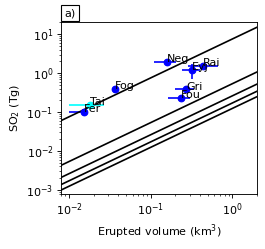

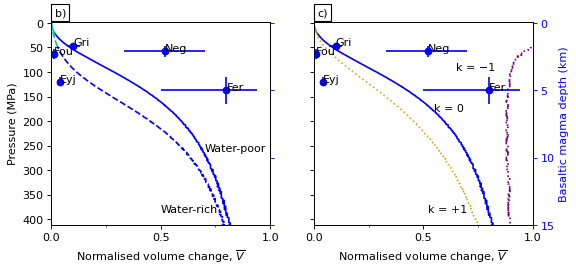

In [18]:
# Observations vs model - basalt

# SO2 versus erupted volume
fig = plt.figure(figsize=(12,10), dpi=80)
gs = plt.GridSpec(3,3)
gs.update(wspace=0.4,hspace=0.3)

# Plot mafic systems
ax1 = plt.subplot(gs[0,0])
ax1.errorbar(df_obs['Volume erupted (km3)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
             df_obs['SO2 emission (Tg)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
             xerr=[df_obs['Volume erupted (km3)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                   df_obs['Min. erupted (km3)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
                  df_obs['Max. erupted (km3)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                  df_obs['Volume erupted (km3)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']],
             yerr=[df_obs['SO2 emission (Tg)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                   df_obs['Min. SO2 (Tg)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
                  df_obs['Max. SO2 (Tg)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                  df_obs['SO2 emission (Tg)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']],
             color='blue', fmt='o', mfc='blue')
ax1.errorbar(df_obs['Volume erupted (km3)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite'],
             df_obs['SO2 emission (Tg)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite'],
             xerr=[df_obs['Volume erupted (km3)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite']-
                   df_obs['Min. erupted (km3)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite'],
                  df_obs['Max. erupted (km3)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite']-
                  df_obs['Volume erupted (km3)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite']],
             yerr=[df_obs['SO2 emission (Tg)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite']-
                   df_obs['Min. SO2 (Tg)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite'],
                  df_obs['Max. SO2 (Tg)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite']-
                  df_obs['SO2 emission (Tg)'][df_obs['Dominant Magma Composition']=='Trachybasalt / Tephrite Basanite']],
             color='cyan', fmt='o', mfc='cyan')
ax1.set_ylabel('$\mathrm{SO_2}$ (Tg)')
ax1.set_xlim(8e-3,2e0)
ax1.set_xscale('log')
ax1.set_xlabel('Erupted volume ' + r'(km$^{3}$)')
ax1.set_ylim(8e-4,2e1)
ax1.set_yscale('log')
# ax1.legend(bbox_to_anchor=(3.7, 0.9))
textstr = 'a)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.016, 1.085, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Plot expected SO2 at each depth
basalt_x = [0.001, 10]
basalt_y = [0.01, 100]

basalt_x_0 = [0.001, 0.1, 10]
basalt_y_0 = [0.00755, 0.755, 75.5]
ax1.plot(basalt_x_0, basalt_y_0, 'k', label='0km')

basalt_x_2 = [0.001, 0.1, 10]
basalt_y_2 = [0.000535, 0.0535, 5.35]
ax1.plot(basalt_x_2, basalt_y_2, color='black', label='2km')

basalt_x_4 = [0.001, 0.1, 10]
basalt_y_4 = [0.000261, 0.0261, 2.61]
ax1.plot(basalt_x_4, basalt_y_4, 'k', label='4km')

basalt_x_6 = [0.001, 0.1, 10]
basalt_y_6 = [0.000171, 0.0171, 1.71]
ax1.plot(basalt_x_6, basalt_y_6, 'k', label='6km')

basalt_x_8 = [0.001, 0.1, 10]
basalt_y_8 = [0.000124, 0.0124, 1.24]
ax1.plot(basalt_x_8, basalt_y_8, 'k', label='8km')

# Volcano names
for print_volname in range(len(df_obs['Volume change (km3)'])):
    if ~np.isnan(df_obs['SO2 emission (Tg)'][print_volname]) == True and df_obs['Volume erupted (km3)'][print_volname]>0 and df_obs['SO2 emission (Tg)'][print_volname]>0:
        if df_obs['Dominant Magma Composition'][print_volname] == 'Basalt / Picro-Basalt' or df_obs['Dominant Magma Composition'][print_volname] == 'Trachybasalt / Tephrite Basanite':
            ax1.text(df_obs['Volume erupted (km3)'][~np.isnan(df_obs['SO2 emission (Tg)'])][print_volname],
                     df_obs['SO2 emission (Tg)'][~np.isnan(df_obs['SO2 emission (Tg)'])][print_volname],
                     df_obs['Volcano Name'][~np.isnan(df_obs['SO2 emission (Tg)'])][print_volname][0:3])
            

            
# plot normalised volume change
fig = plt.figure(figsize=(12,10), dpi=80)
gs = plt.GridSpec(3,3)
gs.update(hspace=0.25,top=1)
min_percolation=np.where(df_basalt[2]['Exsolv_vol_wt'] == find_nearest(df_basalt[2]['Exsolv_vol_wt'][~np.isnan(df_basalt[2]['Exsolv_vol_wt'])], 37)) #find position of depth closest to res_depth
min_percolation=float(min_percolation[0])


# Mafic normalised volume change - water content
ax1 = plt.subplot(gs[0,0])
ax2 = ax1.twinx()
ax2.errorbar(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
             xerr=[df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                   df_obs['Min. normalised volume change'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
                  df_obs['Max. normalised volume change'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                  df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']],
             color='blue', fmt='o', mfc='blue',label='Basalt / Picro-Basalt')
ax1.plot(1/df_basalt[1]['rv_bulk'][0:int(min_percolation):10],df_basalt[1]['Pbar'][0:int(min_percolation):10]/10, color='b', linestyle = '-')
ax1.plot(1/df_basalt[1]['rv_bulk'][int(min_percolation):-1:10],df_basalt[1]['Pbar'][int(min_percolation):-1:10]/10, color='c', linestyle = '-')
ax1.plot(1/df_basalt[3]['rv_bulk'][0:int(min_percolation):10],df_basalt[3]['Pbar'][0:int(min_percolation):10]/10, color='b', linestyle = 'dashed')
ax1.plot(1/df_basalt[3]['rv_bulk'][int(min_percolation):-1:10],df_basalt[3]['Pbar'][int(min_percolation):-1:10]/10, color='c', linestyle = 'dashed')
ax1.set_xlabel('Normalised volume change, $\overline{V}$')
ax1.set_xlim(-0.0, 1.0)
ax1.set_ylim(-26.45/10,4116/10)
ax1.invert_yaxis()
ax2.set_ylim(-0.09635569,15)
ax2.invert_yaxis()
ax1.set_ylabel('Pressure (MPa)')
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax2.yaxis.set_ticklabels([])
ax2.tick_params(axis='y', colors='blue')
ax2.yaxis.label.set_color('blue')
textstr = 'b)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.015, 1.07, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
ax1.text(0.7, 0.4,  'Water-poor', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0.5, 0.1,  'Water-rich', transform=ax1.transAxes, fontsize=10,verticalalignment='top')

# Volcano names
for print_volname in range(len(df_obs['Volume change (km3)'])):
    if ~np.isnan(df_obs['Normalised volume change'][print_volname]) == True and df_obs['Normalised volume change'][print_volname]<15 and df_obs['Depth (km)'][print_volname]<15:
        if df_obs['Dominant Magma Composition'][print_volname] == 'Basalt / Picro-Basalt' or df_obs['Dominant Magma Composition'][print_volname] == 'Trachybasalt / Tephrite Basanite':
            ax2.text(df_obs['Normalised volume change'][~np.isnan(df_obs['Normalised volume change'])][print_volname],
                     df_obs['Depth (km)'][~np.isnan(df_obs['Normalised volume change'])][print_volname],
                     df_obs['Volcano Name'][~np.isnan(df_obs['Normalised volume change'])][print_volname][0:3])

# Mafic normalised volume change - gas segregation
ax1 = plt.subplot(gs[0,1])
ax2 = ax1.twinx()
ax2.errorbar(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
             xerr=[df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                   df_obs['Min. normalised volume change'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
                  df_obs['Max. normalised volume change'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                  df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Basalt / Picro-Basalt']],
             color='blue', fmt='o', mfc='blue',label='Basalt / Picro-Basalt')
ax1.plot(1/df_basalt[0]['rv_bulk'][0:int(min_percolation):10],df_basalt[0]['Pbar'][0:int(min_percolation):10]/10, color='purple', linestyle = 'dotted')
# ax1.plot(1/df_basalt[0]['rv_bulk'][int(min_percolation):-1:10],df_basalt[0]['Pbar'][int(min_percolation):-1:10]/10, color='c', linestyle = 'dotted')
ax1.plot(1/df_basalt[1]['rv_bulk'][0:int(min_percolation):10],df_basalt[1]['Pbar'][0:int(min_percolation):10]/10, color='b', linestyle = '-')
ax1.plot(1/df_basalt[1]['rv_bulk'][int(min_percolation):-1:10],df_basalt[1]['Pbar'][int(min_percolation):-1:10]/10, color='c', linestyle = '-')
ax1.plot(1/df_basalt[2]['rv_bulk'][0:int(min_percolation):10],df_basalt[2]['Pbar'][0:int(min_percolation):10]/10, color='goldenrod', linestyle = 'dotted')
ax1.plot(1/df_basalt[2]['rv_bulk'][int(min_percolation):-1:10],df_basalt[2]['Pbar'][int(min_percolation):-1:10]/10, color='goldenrod', linestyle = 'dotted')
ax1.set_xlabel('Normalised volume change, $\overline{V}$')
ax1.set_xlim(-0.0, 1.0)
ax1.set_ylim(-26.45/10,4116/10)
ax1.invert_yaxis()
ax2.set_ylim(-0.09635569,15)
ax2.invert_yaxis()
ax1.yaxis.set_ticklabels([])
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax2.set_ylabel('Depth (km)')
ax2.set_ylabel('Basaltic magma depth (km)')
ax2.tick_params(axis='y', colors='blue')
ax2.yaxis.label.set_color('blue')
textstr = 'c)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.015, 1.07, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
ax1.text(0.55, 0.6,  'k = 0', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0.65, 0.8,  'k = −1', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0.52, 0.1,  'k = +1', transform=ax1.transAxes, fontsize=10,verticalalignment='top')

# Volcano names
for print_volname in range(len(df_obs['Volume change (km3)'])):
    if ~np.isnan(df_obs['Normalised volume change'][print_volname]) == True and df_obs['Normalised volume change'][print_volname]<15 and df_obs['Depth (km)'][print_volname]<15:
        if df_obs['Dominant Magma Composition'][print_volname] == 'Basalt / Picro-Basalt' or df_obs['Dominant Magma Composition'][print_volname] == 'Trachybasalt / Tephrite Basanite':
            ax2.text(df_obs['Normalised volume change'][~np.isnan(df_obs['Normalised volume change'])][print_volname],
                     df_obs['Depth (km)'][~np.isnan(df_obs['Normalised volume change'])][print_volname],
                     df_obs['Volcano Name'][~np.isnan(df_obs['Normalised volume change'])][print_volname][0:3])


### Fig. 7

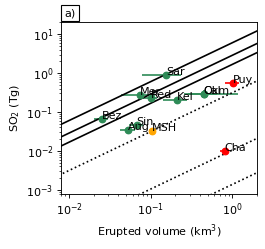

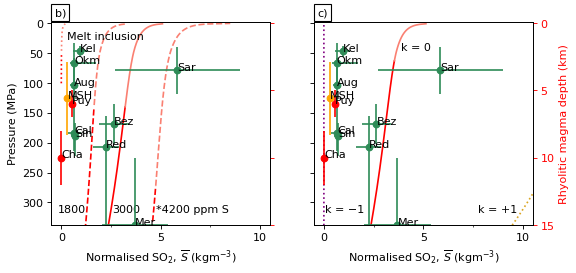

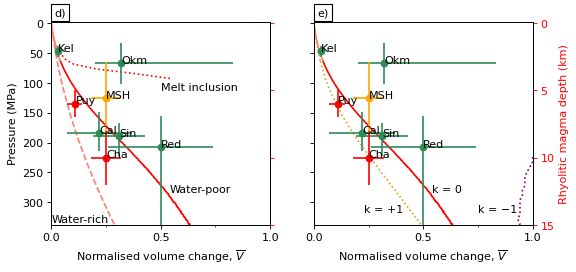

In [19]:
# Observations vs model - rhyolite
# SO2 versus erupted volume
fig = plt.figure(figsize=(12,10), dpi=80)
gs = plt.GridSpec(3,3)
gs.update(wspace=0.4,hspace=0.3)


# Plot silicic systems
ax1 = plt.subplot(gs[0,1])
ax1.errorbar(df_obs['Volume erupted (km3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
             df_obs['SO2 emission (Tg)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
             xerr=[df_obs['Volume erupted (km3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                   df_obs['Min. erupted (km3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
                  df_obs['Max. erupted (km3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                  df_obs['Volume erupted (km3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']],
             yerr=[df_obs['SO2 emission (Tg)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                   df_obs['Min. SO2 (Tg)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
                  df_obs['Max. SO2 (Tg)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                  df_obs['SO2 emission (Tg)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']],
             color='seagreen', fmt='o', mfc='seagreen')
ax1.errorbar(df_obs['Volume erupted (km3)'][df_obs['Dominant Magma Composition']=='Dacite'],
             df_obs['SO2 emission (Tg)'][df_obs['Dominant Magma Composition']=='Dacite'],
             xerr=[df_obs['Volume erupted (km3)'][df_obs['Dominant Magma Composition']=='Dacite']-
                   df_obs['Min. erupted (km3)'][df_obs['Dominant Magma Composition']=='Dacite'],
                  df_obs['Max. erupted (km3)'][df_obs['Dominant Magma Composition']=='Dacite']-
                  df_obs['Volume erupted (km3)'][df_obs['Dominant Magma Composition']=='Dacite']],
             yerr=[df_obs['SO2 emission (Tg)'][df_obs['Dominant Magma Composition']=='Dacite']-
                   df_obs['Min. SO2 (Tg)'][df_obs['Dominant Magma Composition']=='Dacite'],
                  df_obs['Max. SO2 (Tg)'][df_obs['Dominant Magma Composition']=='Dacite']-
                  df_obs['SO2 emission (Tg)'][df_obs['Dominant Magma Composition']=='Dacite']],
             color='orange', fmt='o', mfc='orange')
ax1.errorbar(df_obs['Volume erupted (km3)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
             df_obs['SO2 emission (Tg)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
             xerr=[df_obs['Volume erupted (km3)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                   df_obs['Min. erupted (km3)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
                  df_obs['Max. erupted (km3)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                  df_obs['Volume erupted (km3)'][df_obs['Dominant Magma Composition']=='Rhyolite']],
             yerr=[df_obs['SO2 emission (Tg)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                   df_obs['Min. SO2 (Tg)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
                  df_obs['Max. SO2 (Tg)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                  df_obs['SO2 emission (Tg)'][df_obs['Dominant Magma Composition']=='Rhyolite']],
             color='red', fmt='o', mfc='red')
ax1.set_ylabel('$\mathrm{SO_2}$ (Tg)')
ax1.set_xlim(8e-3,2e0)
ax1.set_xscale('log')
ax1.set_xlabel('Erupted volume ' + r'(km$^{3}$)')
ax1.set_ylim(8e-4,2e1)
ax1.set_yscale('log')
# ax1.legend(bbox_to_anchor=(3.7, 0.9))
# ax1.yaxis.set_ticklabels([])
textstr = 'a)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.016, 1.085, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)

# Plot expected SO2 at each depth
rhyolite_x_0 = [0.001, 0.1, 10]
rhyolite_y_0 = [0.00605, 0.605, 60.5]
ax1.plot(rhyolite_x_0, rhyolite_y_0, 'k', label='0km')

rhyolite_x_10 = [0.001, 0.1, 10]
rhyolite_y_10 = [0.00288, 0.288, 28.8]
ax1.plot(rhyolite_x_10, rhyolite_y_10, 'k', label='10km')

rhyolite_x_20 = [0.001, 0.1, 10]
rhyolite_y_20 = [0.00168, 0.168, 16.8]
ax1.plot(rhyolite_x_20, rhyolite_y_20, 'k', label='20km')

rhyolite_MI_x_0 = [0.001, 0.1, 10]
rhyolite_MI_y_0 = [0.000315, 0.0315, 3.15]
ax1.plot(rhyolite_MI_x_0, rhyolite_MI_y_0, 'k:', label='0km')

rhyolite_MI_x_2 = [0.001, 0.1, 10]
rhyolite_MI_y_2 = [0.0000105, 0.00105 ,0.105]
ax1.plot(rhyolite_MI_x_2, rhyolite_MI_y_2, 'k:', label='2km')

rhyolite_MI_x_4 = [0.001, 0.1, 10]
rhyolite_MI_y_4 = [0.00000138, 0.000138, 0.0138]
ax1.plot(rhyolite_MI_x_4, rhyolite_MI_y_4, 'k:', label='4km')


# Volcano names
for print_volname in range(len(df_obs['Volume change (km3)'])):
    if ~np.isnan(df_obs['SO2 emission (Tg)'][print_volname]) == True and df_obs['Volume erupted (km3)'][print_volname]>0 and df_obs['SO2 emission (Tg)'][print_volname]>0:
        if df_obs['Dominant Magma Composition'][print_volname] == 'Dacite' or df_obs['Dominant Magma Composition'][print_volname] == 'Trachyte / Trachydacite' or df_obs['Dominant Magma Composition'][print_volname] == 'Rhyolite' or df_obs['Dominant Magma Composition'][print_volname] == 'Andesite / Basaltic Andesite':
            ax1.text(df_obs['Volume erupted (km3)'][~np.isnan(df_obs['SO2 emission (Tg)'])][print_volname],
                     df_obs['SO2 emission (Tg)'][~np.isnan(df_obs['SO2 emission (Tg)'])][print_volname],
                     df_obs['Volcano Name'][~np.isnan(df_obs['SO2 emission (Tg)'])][print_volname][0:3])

#########################################################################################################################################

# plot normalised SO2
fig = plt.figure(figsize=(12,10), dpi=80)
gs = plt.GridSpec(3,3)
gs.update(hspace=0.25,top=1)

# normalised SO2 - sulfur-rich sulfur-poor
ax1 = plt.subplot(gs[0,0])
ax2 = ax1.twinx()
        
# percolation threshold - sulfur-rich sulfur-poor
min_percolation0=np.where(df_rhyolite_rhy[0]['Exsolv_vol_wt'] == find_nearest(df_rhyolite_rhy[0]['Exsolv_vol_wt'][~np.isnan(df_rhyolite_rhy[0]['Exsolv_vol_wt'])], 17)) #find position of depth closest to res_depth
min_percolation0=float(min_percolation0[0])
min_percolation1=np.where(df_rhyolite_rhy[1]['Exsolv_vol_wt'] == find_nearest(df_rhyolite_rhy[1]['Exsolv_vol_wt'][~np.isnan(df_rhyolite_rhy[1]['Exsolv_vol_wt'])], 17)) #find position of depth closest to res_depth
min_percolation1=float(min_percolation1[0])
min_percolation_S0=np.where(df_rhyolite_S[0]['Exsolv_vol_wt'] == find_nearest(df_rhyolite_S[0]['Exsolv_vol_wt'][~np.isnan(df_rhyolite_S[0]['Exsolv_vol_wt'])], 17)) #find position of depth closest to res_depth
min_percolation_S0=float(min_percolation_S0[0])
min_percolation_S2=np.where(df_rhyolite_S[2]['Exsolv_vol_wt'] == find_nearest(df_rhyolite_S[2]['Exsolv_vol_wt'][~np.isnan(df_rhyolite_S[2]['Exsolv_vol_wt'])], 17)) #find position of depth closest to res_depth
min_percolation_S2=float(min_percolation_S2[0])

# Silicic normalised SO2 - sulfur content
ax1 = plt.subplot(gs[0,0])
ax2 = ax1.twinx()
ax2.errorbar(df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
             xerr=[df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                   df_obs['Min. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
                  df_obs['Max. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                  df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']],
             color='seagreen', fmt='o', mfc='seagreen',label='Andesite / Basaltic Andesite')
ax2.errorbar(df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Dacite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite'],
             xerr=[df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Dacite']-
                   df_obs['Min. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Dacite'],
                  df_obs['Max. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Dacite']-
                  df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Dacite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Dacite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']],
             color='orange', fmt='o', mfc='orange',label='Dacite')
ax2.errorbar(df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
             xerr=[df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                   df_obs['Min. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
                  df_obs['Max. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                  df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Rhyolite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']],
             color='red', fmt='o', mfc='red',label='Rhyolite')
ax1.plot(df_rhyolite_rhy[0]['mS_released'][0:int(min_percolation0):80],df_rhyolite_rhy[0]['Pbar'][0:int(min_percolation0):80]/10, color='r', linestyle = 'dotted')
ax1.plot(df_rhyolite_rhy[0]['mS_released'][int(min_percolation0):-1:10],df_rhyolite_rhy[0]['Pbar'][int(min_percolation0):-1:10]/10, color='salmon', linestyle = 'dotted')
ax1.plot(df_rhyolite_rhy[1]['mS_released'][0:int(min_percolation1):10],df_rhyolite_rhy[1]['Pbar'][0:int(min_percolation1):10]/10, color='r', linestyle = '-')
ax1.plot(df_rhyolite_rhy[1]['mS_released'][int(min_percolation1):-1:10],df_rhyolite_rhy[1]['Pbar'][int(min_percolation1):-1:10]/10, color='salmon', linestyle = '-')
ax1.plot(df_rhyolite_S[0]['mS_released'][0:int(min_percolation_S0):80],df_rhyolite_S[0]['Pbar'][0:int(min_percolation_S0):80]/10, color='r', linestyle = 'dashed')
ax1.plot(df_rhyolite_S[0]['mS_released'][int(min_percolation_S0):-1:10],df_rhyolite_S[0]['Pbar'][int(min_percolation_S0):-1:10]/10, color='salmon', linestyle = 'dashed')
ax1.plot(df_rhyolite_S[2]['mS_released'][0:int(min_percolation_S2):10],df_rhyolite_S[2]['Pbar'][0:int(min_percolation_S2):10]/10, color='r', linestyle = 'dashed')
ax1.plot(df_rhyolite_S[2]['mS_released'][int(min_percolation_S2):-1:10],df_rhyolite_S[2]['Pbar'][int(min_percolation_S2):-1:10]/10, color='salmon', linestyle = 'dashed')
ax1.set_xlabel('Normalised $\mathrm{SO_2}$, ' + r'$\overline{S}$ (kgm$^{-3}$)')
ax1.set_xlim(-0.5, 10.5)
ax1.set_ylim(-26.45/10,3381/10)
ax1.invert_yaxis()
ax2.set_ylim(-0.09635569,15)
ax2.invert_yaxis()
ax1.set_ylabel('Pressure (MPa)')
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2.5))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax2.yaxis.set_ticklabels([])
ax2.tick_params(axis='y', colors='red')
ax2.yaxis.label.set_color('red')
textstr = 'b)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.015, 1.07, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
ax1.text(0.03, 0.1,  '1800', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0.28, 0.1,  '3000', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0.48, 0.1,  '*4200 ppm S', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0.07, 0.95,  'Melt inclusion', transform=ax1.transAxes, fontsize=10,verticalalignment='top')

# Volcano names
for print_volname in range(len(df_obs['Volume change (km3)'])):
    if ~np.isnan(df_obs['Normalised SO2 (Tg km-3)'][print_volname]) == True and df_obs['Normalised SO2 (Tg km-3)'][print_volname]<15 and df_obs['Depth (km)'][print_volname]<15.1:
        if df_obs['Dominant Magma Composition'][print_volname] == 'Andesite / Basaltic Andesite' or df_obs['Dominant Magma Composition'][print_volname] == 'Dacite' or df_obs['Dominant Magma Composition'][print_volname] == 'Rhyolite':
            ax2.text(df_obs['Normalised SO2 (Tg km-3)'][~np.isnan(df_obs['Normalised SO2 (Tg km-3)'])][print_volname],
                     df_obs['Depth (km)'][~np.isnan(df_obs['Normalised SO2 (Tg km-3)'])][print_volname],
                     df_obs['Volcano Name'][~np.isnan(df_obs['Normalised SO2 (Tg km-3)'])][print_volname][0:3])
            
# Mafic normalised SO2 - gas segregation
ax1 = plt.subplot(gs[0,1])
ax2 = ax1.twinx()
ax2.errorbar(df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
             xerr=[df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                   df_obs['Min. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
                  df_obs['Max. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                  df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']],
             color='seagreen', fmt='o', mfc='seagreen',label='Andesite / Basaltic Andesite')
ax2.errorbar(df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Dacite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite'],
             xerr=[df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Dacite']-
                   df_obs['Min. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Dacite'],
                  df_obs['Max. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Dacite']-
                  df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Dacite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Dacite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']],
             color='orange', fmt='o', mfc='orange',label='Dacite')
ax2.errorbar(df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
             xerr=[df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                   df_obs['Min. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
                  df_obs['Max. normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                  df_obs['Normalised SO2 (Tg km-3)'][df_obs['Dominant Magma Composition']=='Rhyolite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']],
             color='red', fmt='o', mfc='red',label='Rhyolite')
ax1.plot(0*df_rhyolite_5H2O[0]['mS_released'],df_rhyolite_5H2O[0]['Pbar']/10, color='purple', linestyle = 'dotted')
ax1.plot(df_rhyolite_5H2O[1]['mS_released'][0:int(min_percolation):10],df_rhyolite_5H2O[1]['Pbar'][0:int(min_percolation):10]/10, color='r', linestyle = '-')
ax1.plot(df_rhyolite_5H2O[1]['mS_released'][int(min_percolation):-1:10],df_rhyolite_5H2O[1]['Pbar'][int(min_percolation):-1:10]/10, color='salmon', linestyle = '-')
ax1.plot(2*df_rhyolite_5H2O[2]['mS_released'][0:int(min_percolation):10],df_rhyolite_5H2O[2]['Pbar'][0:int(min_percolation):10]/10, color='goldenrod', linestyle = 'dotted')
ax1.plot(2*df_rhyolite_5H2O[2]['mS_released'][int(min_percolation):-1:10],df_rhyolite_5H2O[2]['Pbar'][int(min_percolation):-1:10]/10, color='goldenrod', linestyle = 'dotted')
ax1.set_xlabel('Normalised $\mathrm{SO_2}$, ' + r'$\overline{S}$ (kgm$^{-3}$)')
ax1.set_xlim(-0.5, 10.5)
ax1.set_ylim(-26.45/10,3381/10)
ax1.invert_yaxis()
ax2.set_ylim(-0.09635569,15)
ax2.invert_yaxis()
ax1.yaxis.set_ticklabels([])
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2.5))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax2.set_ylabel('Rhyolitic magma depth (km)')
ax2.tick_params(axis='y', colors='red')
ax2.yaxis.label.set_color('red')
textstr = 'c)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.015, 1.07, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
ax1.text(0.4, 0.9,  'k = 0', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0.05, 0.1,  'k = −1', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0.75, 0.1,  'k = +1', transform=ax1.transAxes, fontsize=10,verticalalignment='top')

# Volcano names
for print_volname in range(len(df_obs['Volume change (km3)'])):
    if ~np.isnan(df_obs['Normalised SO2 (Tg km-3)'][print_volname]) == True and df_obs['Normalised SO2 (Tg km-3)'][print_volname]<15 and df_obs['Depth (km)'][print_volname]<15.1:
        if df_obs['Dominant Magma Composition'][print_volname] == 'Andesite / Basaltic Andesite' or df_obs['Dominant Magma Composition'][print_volname] == 'Dacite' or df_obs['Dominant Magma Composition'][print_volname] == 'Rhyolite':
            ax2.text(df_obs['Normalised SO2 (Tg km-3)'][~np.isnan(df_obs['Normalised SO2 (Tg km-3)'])][print_volname],
                     df_obs['Depth (km)'][~np.isnan(df_obs['Normalised SO2 (Tg km-3)'])][print_volname],
                     df_obs['Volcano Name'][~np.isnan(df_obs['Normalised SO2 (Tg km-3)'])][print_volname][0:3])

#########################################################################################################################################
# plot volume change
fig = plt.figure(figsize=(12,10), dpi=80)
gs = plt.GridSpec(3,3)
gs.update(hspace=0.25,top=1)

# Rhyolite percolation threshold
min_percolation0=np.where(df_rhyolite_rhy[0]['Exsolv_vol_wt'] == find_nearest(df_rhyolite_rhy[0]['Exsolv_vol_wt'][~np.isnan(df_rhyolite_rhy[0]['Exsolv_vol_wt'])], 17)) #find position of depth closest to res_depth
min_percolation0=float(min_percolation0[0])
min_percolation1=np.where(df_rhyolite_rhy[1]['Exsolv_vol_wt'] == find_nearest(df_rhyolite_rhy[1]['Exsolv_vol_wt'][~np.isnan(df_rhyolite_rhy[1]['Exsolv_vol_wt'])], 17)) #find position of depth closest to res_depth
min_percolation1=float(min_percolation1[0])
min_percolation_S0=np.where(df_rhyolite_S[0]['Exsolv_vol_wt'] == find_nearest(df_rhyolite_S[0]['Exsolv_vol_wt'][~np.isnan(df_rhyolite_S[0]['Exsolv_vol_wt'])], 17)) #find position of depth closest to res_depth
min_percolation_S0=float(min_percolation_S0[0])
min_percolation_S2=np.where(df_rhyolite_S[2]['Exsolv_vol_wt'] == find_nearest(df_rhyolite_S[2]['Exsolv_vol_wt'][~np.isnan(df_rhyolite_S[2]['Exsolv_vol_wt'])], 17)) #find position of depth closest to res_depth
min_percolation_S2=float(min_percolation_S2[0])

# normalised volume change - water content
ax1 = plt.subplot(gs[0,0])
ax2 = ax1.twinx()
ax2.errorbar(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
             xerr=[df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                   df_obs['Min. normalised volume change'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
                  df_obs['Max. normalised volume change'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                  df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']],
             color='seagreen', fmt='o', mfc='seagreen',label='Andesite / Basaltic Andesite')
ax2.errorbar(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Dacite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite'],
             xerr=[df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Dacite']-
                   df_obs['Min. normalised volume change'][df_obs['Dominant Magma Composition']=='Dacite'],
                  df_obs['Max. normalised volume change'][df_obs['Dominant Magma Composition']=='Dacite']-
                  df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Dacite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Dacite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']],
             color='orange', fmt='o', mfc='orange',label='Dacite')
ax2.errorbar(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Rhyolite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
             xerr=[df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                   df_obs['Min. normalised volume change'][df_obs['Dominant Magma Composition']=='Rhyolite'],
                  df_obs['Max. normalised volume change'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                  df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Rhyolite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']],
             color='red', fmt='o', mfc='red',label='Rhyolite')
ax1.plot(1/df_rhyolite_rhy[0]['rv_bulk'][0:int(min_percolation0):80],df_rhyolite_rhy[0]['Pbar'][0:int(min_percolation0):80]/10, color='r', linestyle = 'dotted')
ax1.plot(1/df_rhyolite_rhy[0]['rv_bulk'][int(min_percolation0):-1:10],df_rhyolite_rhy[0]['Pbar'][int(min_percolation0):-1:10]/10, color='salmon', linestyle = 'dotted')
ax1.plot(1/df_rhyolite_5H2O[1]['rv_bulk'][0:int(min_percolation):10],df_rhyolite_5H2O[1]['Pbar'][0:int(min_percolation):10]/10, color='r', linestyle = '-')
ax1.plot(1/df_rhyolite_5H2O[1]['rv_bulk'][int(min_percolation):-1:10],df_rhyolite_5H2O[1]['Pbar'][int(min_percolation):-1:10]/10, color='salmon', linestyle = '-')
ax1.plot(1/df_rhyolite_5H2O[3]['rv_bulk'][0:int(min_percolation):10],df_rhyolite_5H2O[3]['Pbar'][0:int(min_percolation):10]/10, color='r', linestyle = 'dashed')
ax1.plot(1/df_rhyolite_5H2O[3]['rv_bulk'][int(min_percolation):-1:10],df_rhyolite_5H2O[3]['Pbar'][int(min_percolation):-1:10]/10, color='salmon', linestyle = 'dashed')
ax1.set_xlabel('Normalised volume change, $\overline{V}$')
ax1.set_xlim(-0.0, 1.0)
ax1.set_ylim(-26.45/10,3381/10)
ax1.invert_yaxis()
ax2.set_ylim(-0.09635569,15)
ax2.invert_yaxis()
ax1.set_ylabel('Pressure (MPa)')
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax2.yaxis.set_ticklabels([])
ax2.tick_params(axis='y', colors='red')
ax2.yaxis.label.set_color('red')
textstr = 'd)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.015, 1.07, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
ax1.text(0.54, 0.2,  'Water-poor', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0, 0.05,  'Water-rich', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0.5, 0.7,  'Melt inclusion', transform=ax1.transAxes, fontsize=10,verticalalignment='top')

# Volcano names
for print_volname in range(len(df_obs['Volume change (km3)'])):
    if ~np.isnan(df_obs['Normalised volume change'][print_volname]) == True and df_obs['Normalised volume change'][print_volname]<15 and df_obs['Depth (km)'][print_volname]<15.1:
        if df_obs['Dominant Magma Composition'][print_volname] == 'Andesite / Basaltic Andesite' or df_obs['Dominant Magma Composition'][print_volname] == 'Dacite' or df_obs['Dominant Magma Composition'][print_volname] == 'Rhyolite':
            ax2.text(df_obs['Normalised volume change'][~np.isnan(df_obs['Normalised volume change'])][print_volname],
                     df_obs['Depth (km)'][~np.isnan(df_obs['Normalised volume change'])][print_volname],
                     df_obs['Volcano Name'][~np.isnan(df_obs['Normalised volume change'])][print_volname][0:3])
            
# normalised volume change - gas segregation
ax1 = plt.subplot(gs[0,1])
ax2 = ax1.twinx()
ax2.errorbar(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
             xerr=[df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                   df_obs['Min. normalised volume change'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
                  df_obs['Max. normalised volume change'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                  df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Andesite / Basaltic Andesite']],
             color='seagreen', fmt='o', mfc='seagreen',label='Andesite / Basaltic Andesite')
ax2.errorbar(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Dacite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite'],
             xerr=[df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Dacite']-
                   df_obs['Min. normalised volume change'][df_obs['Dominant Magma Composition']=='Dacite'],
                  df_obs['Max. normalised volume change'][df_obs['Dominant Magma Composition']=='Dacite']-
                  df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Dacite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Dacite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Dacite']],
             color='orange', fmt='o', mfc='orange',label='Dacite')
ax2.errorbar(df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Rhyolite'],
             df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
             xerr=[df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                   df_obs['Min. normalised volume change'][df_obs['Dominant Magma Composition']=='Rhyolite'],
                  df_obs['Max. normalised volume change'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                  df_obs['Normalised volume change'][df_obs['Dominant Magma Composition']=='Rhyolite']],
             yerr=[df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                   df_obs['Min. depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite'],
                  df_obs['Max. depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']-
                  df_obs['Depth (km)'][df_obs['Dominant Magma Composition']=='Rhyolite']],
             color='red', fmt='o', mfc='red',label='Rhyolite')
ax1.plot(1/df_rhyolite_5H2O[0]['rv_bulk'][0:int(min_percolation):80],df_rhyolite_5H2O[0]['Pbar'][0:int(min_percolation):80]/10, color='purple', linestyle = 'dotted')
ax1.plot(1/df_rhyolite_5H2O[1]['rv_bulk'][0:int(min_percolation):10],df_rhyolite_5H2O[1]['Pbar'][0:int(min_percolation):10]/10, color='r', linestyle = '-')
ax1.plot(1/df_rhyolite_5H2O[1]['rv_bulk'][int(min_percolation):-1:10],df_rhyolite_5H2O[1]['Pbar'][int(min_percolation):-1:10]/10, color='salmon', linestyle = '-')
ax1.plot(1/df_rhyolite_5H2O[2]['rv_bulk'][0:int(min_percolation):10],df_rhyolite_5H2O[2]['Pbar'][0:int(min_percolation):10]/10, color='goldenrod', linestyle = 'dotted')
ax1.plot(1/df_rhyolite_5H2O[2]['rv_bulk'][int(min_percolation):-1:10],df_rhyolite_5H2O[2]['Pbar'][int(min_percolation):-1:10]/10, color='goldenrod', linestyle = 'dotted')
ax1.set_xlabel('Normalised volume change, $\overline{V}$')
ax1.set_xlim(-0.0, 1.0)
ax1.set_ylim(-26.45/10,3381/10)
ax1.invert_yaxis()
ax2.set_ylim(-0.09635569,15)
ax2.invert_yaxis()
ax1.yaxis.set_ticklabels([])
ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.0f"))
ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax2.set_ylabel('Rhyolitic magma depth (km)')
ax2.tick_params(axis='y', colors='red')
ax2.yaxis.label.set_color('red')
textstr = 'e)'
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax1.text(0.015, 1.07, textstr, transform=ax1.transAxes, fontsize=10,verticalalignment='top', bbox=props)
ax1.text(0.54, 0.2,  'k = 0', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0.75, 0.1,  'k = −1', transform=ax1.transAxes, fontsize=10,verticalalignment='top')
ax1.text(0.23, 0.1,  'k = +1', transform=ax1.transAxes, fontsize=10,verticalalignment='top')

# Volcano names
for print_volname in range(len(df_obs['Volume change (km3)'])):
    if ~np.isnan(df_obs['Normalised volume change'][print_volname]) == True and df_obs['Normalised volume change'][print_volname]<15 and df_obs['Depth (km)'][print_volname]<15.1:
        if df_obs['Dominant Magma Composition'][print_volname] == 'Andesite / Basaltic Andesite' or df_obs['Dominant Magma Composition'][print_volname] == 'Dacite' or df_obs['Dominant Magma Composition'][print_volname] == 'Rhyolite':
            ax2.text(df_obs['Normalised volume change'][~np.isnan(df_obs['Normalised volume change'])][print_volname],
                     df_obs['Depth (km)'][~np.isnan(df_obs['Normalised volume change'])][print_volname],
                     df_obs['Volcano Name'][~np.isnan(df_obs['Normalised volume change'])][print_volname][0:3])
            


## References


- Gudmundsson, A. (2005). The effects of layering and local stresses in composite volcanoes on dyke emplacement and volcanic hazards. Comptes Rendus Geoscience, 337(13), 1216-1222.
- Heap, M. J., Villeneuve, M., Albino, F., Farquharson, J. I., Brothelande, E., Amelung, F., ... & Baud, P. (2020). Towards more realistic values of elastic moduli for volcano modelling. Journal of volcanology and geothermal research, 390, 106684.
- Kilbride, B. M., Edmonds, M., & Biggs, J. (2016). Observing eruptions of gas-rich compressible magmas from space. Nature Communications, 7(1), 1-8.
- Liggins, P., Shorttle, O., & Rimmer, P. B. (2020). Can volcanism build hydrogen-rich early atmospheres?. Earth and Planetary Science Letters, 550, 116546.
- Liggins, P., Jordan, S., Rimmer, P. B., & Shorttle, O. (2022). Growth and evolution of secondary volcanic atmospheres: I. Identifying the geological character of hot rocky planets. Journal of Geophysical Research: Planets, 127(7), e2021JE007123.
- Yip, S. T. H., Biggs, J., Edmonds, M., Liggins, P., & Shorttle, O. (2022). Contrasting volcanic deformation in arc and ocean island settings due to exsolution of magmatic water. Geochemistry, Geophysics, Geosystems, 23(7), e2022GC010387.
